# Sentiment Analysis Model


## Background:

*Sentiment Analysis* is a branch of Natural Language Processing (NLP) that allows us to determine algorithmically whether a statement or document is “positive” or “negative”.

Sentiment analysis is a technology of increasing importance in the modern society as it allows individuals, organizations and governments to detect trends in public opinion by analyzing social media content. Keeping abreast of socio-political developments is especially important during periods of war and political instability, such as year 2022, when russia started the unprovoked war in Ukraine. Politicians, media and organizations can benefit from sentiment analysis by making appropriate changes to their campaigning, news coverage, and strategies respectively.

The purpose of this project is to compute the sentiment of text information – in our case, social media posts/tweets and news articles posted recently on the war of Ukraine against russia - and answer the research question: **“What can public opinion tell us about the russia’s war against Ukraine in 2022-2023?”** The goal is to essentially use sentiment analysis on Twitter, Reddit, Facebook and other social media and news platforms to get insights into the war. For this project, you are encouraged to use data from multiple sources. You are encouraged to develop your sentiment analysis models and compare those to existing models available as Python libraries or on-Cloud.

In addition, based on your sentiment analysis results (especially looking at posts/tweets with negative and positive sentiment, as posts/tweets with neutral sentiment are less informative), you will need to identify factors/reasons/topics that drive sentiment. Consider that you have been hired by a government agency or a news outlet as a consultant to gauge how Ukraine and the war is viewed internationally and suggest actions that could improve Ukraine’s image. Your task is to analyze social media posts/tweets and to identify key factors/reasons/topics from those in order to determine how Ukraine is perceived on the international scene and to write a report presenting your findings and your suggestions to the Ukrainian government and international NGOs for changes in their current portfolio of strategies that are projected to have a positive impact on Ukraine’s international presence and image. If necessary, you may compliment your analysis of posts/tweets by analyzing news articles from traditional media.

When making your conclusions and recommendations be careful to distinguish sentiment about Ukraine, sentiment about russia, sentiment about the war, sentiment about opinions of Elon Musk, etc.

In [ ]:
use_colab_gdrive = True

if use_colab_gdrive:
    # Important note: Version 1.0.2 has incompatibility with newer versions of scikit-learn.
    # Traning and testing was done with version 1.0.2:
    !pip install scikit-learn==1.0.2

## Part 1 – Sentiment modeling:

A dataset of classified tweets to train your sentiment analysis models is provided. The *sentiment_analysis.csv* file contains tweets that have had their sentiments already analyzed and recorded as binary values 0 (negative) and 1 (positive). Each line is a single tweet, which may contain multiple sentences despite their brevity. The comma-separated fields of each line are:

- 0 ID Tweet ID
- 1 text the text of the tweet
- 2 label the polarity of each tweet (0 = negative sentiment, 1 = positive sentiment)

The dataset has been collected directly from the web, so it may contain html tags, hashtags, and user tags. You may use this dataset or any other dataset from the web to train and validate your sentiment models.
Prepare the data using TF-IDF or Bag of Words (word frequency) as your feature engineering technique. Train at least four classification algorithms on the training data: logistic regression, k-NN, Naive Bayes, SVM, decision trees, Random Forest, XGBoost, and Deep Learning models, where each tweet is considered a single observation/example, and the target variable is the sentiment value, which is either positive or negative. Evaluate each model on the test data to obtain accuracy measures. Perform hyperparameter tuning and cross-validation.

If you find out that the dataset provided in sentiment_analysis.csv file is not suitable for your purposes, feel free to use an alternative dataset available on the web. Among other datasets, you may consider:

- https://www.kaggle.com/code/avinandandutta/twitter-sentiment-analysis-russia-ukraine-conflict
- https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech
- https://www.kaggle.com/datasets/bittlingmayer/amazonreviews

Select the trained model with the best performance to use in Part 2.

#### Global control variable:

In [ ]:
# Under sampling:
perform_undersampling = False

# Control cross-validation, tuning, and testing:
perform_cv = True
perform_tuning = False
perform_testing = True

# Training or testing the RNN requires tensorflow:
perform_RNN_training = False
perform_RNN_testing = True

#### Import the basic libraries:

In [ ]:
import os
import sys
import requests
print(sys.version)

3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

### 1.1. Data Cleaning:

In [ ]:
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
try:
    import contractions
except:
    !pip install contractions
    import contractions

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ali\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ali\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ali\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def clean_data(text):
    """
    Rremoves various types of unwanted information, including hashtags, HTML tags, URLs, etc.
    """

    # Remove hashtags:
    text = re.sub("#[\w]*","", text)

    # Remove twitter Return handles:
    text = re.sub("RT @[\w]*:","", text)

    # Remove user tags:
    text = re.sub("@[\w]*","", text)

    # Remove HTML tags:
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove links:
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)

    # Remove escape characters:
    text = re.sub(r"\r+|\n+|\t+", " ", text)

    # Lowercase the letters:
    text = text.lower()

    # Fix contractions:
    text = contractions.fix(text)

    # Remove punctuations:
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)

    # Filter non-letters:
    text = re.sub("[^a-zA-Z]", " ", text)

    # Tokenize to words:
    token = nltk.word_tokenize(text)

    # Define stopwords:
    neg_words = ["aren't", "aren", "ain", "can't", "cannot", "couldn't", "couldn",
                 "didn't", "didn", "doesn", "doesn't", "don", "don't", "hadn't", "hadn",
                 "hasn't", "hasn", "haven't", "haven", "isn't", "isn", "mightn't", "mightn",
                 "mustn't", "mustn", "needn't", "needn", "no", "nor", "not", "shan't", "shan",
                 "shouldn't", "shouldn", "wasn't", "wasn", "weren't", "weren", "won't", "won", "wouldn't", "wouldn"]
    sw = [w for w in stopwords.words('english') if w not in neg_words] + ['would']

    # Lemmatize:
    wn = nltk.stem.WordNetLemmatizer()
    text = [wn.lemmatize(w) for w in token if w not in sw]

    # Rejoin the words:
    return " ".join(text)

First, let's check if there is a clean data file available. If not, we will apply the `clean_data` function to the dataframe to ensure it is ready for analysis. The `clean_data` function provides step-by-step instructions for data cleaning. After cleaning, we need to check for any null values in the `'label'` and `'text'` columns. Since we already know that there are only few missing values, we can simply drop those rows. Finally, we should save the clean dataframe to avoid having to repeat the cleaning process in future runs.

In [ ]:
if not use_colab_gdrive:
    filename = "sentiment_analysis.csv"
    url = "clean_" + filename

    # Check to see if clean data file exists:
    if os.path.isfile(url):
        print("'{}' already exists.\n".format(url))
        df = pd.read_csv(url)
    else:
        url = filename
        df = pd.read_csv(url)
        df = df[['text', 'label']]

        # Clean data file:
        df['text'] = df['text'].apply(clean_data)

        # Check for null values in columns:
        idx = df[df['label'].isna()].index
        print("Null values in 'label' column:", len(idx))
        df = df.drop(idx)

        # Replace empty strings with nan values:
        df['text'] = df['text'].replace('', np.nan)
        idx = df[df['text'].isna()].index
        print("Null values in 'text' column:", len(idx))
        df = df.drop(idx)

        # Save clean data file:
        url = "clean_" + filename
        df.to_csv(url, index=False)

    print(f"Dataframe shape: {df.shape}")
else:
    # set the URL for the 'clean_sentiment_analysis.csv' file
    url = "https://drive.google.com/file/d/17LFrUNu0LPoRGLkZkpkyVIAKTnuXBAuU/view?usp=share_link"
    url = "https://drive.google.com/uc?id=" + url.split('/')[-2]

    # create a pandas dataframe from the CSV file
    df = pd.read_csv(url)

'clean_sentiment_analysis.csv' already exists.

Dataframe shape: (550282, 2)


In [ ]:
df.head()

,text,label
0,josh jenkins looking forward tab breeder crown...,1
1,congratulation pakistan becoming world odds,1
2,september taking maine mendoza surprise thanks...,1
3,newly painted wall thanks million custodial pa...,1
4,excited announce july feschotte lab relocating...,1


### 1.2. Feature Engineering:

We have the option to use either TF-IDF or Bag of Words for feature engineering. To simplify the process of chaining multiple estimators together and treating them as a single unit, we can use the `Pipeline` class from the `sklearn` library. However, when performing cross-validation, it's important to only cross-validate the classifier and not the feature extraction step to ensure consistent results across all folds. Therefore, when building the pipeline, we need to ensure that the vocabulary is learned from the training data and then applied to the test data, rather than learning a new set of vocabulary for each fold of the cross-validation.

For deep learning models like RNNs, using TF-IDF or Bag of Words for feature engineering is not recommended. These techniques provide sparse discrete representations of the data, while deep learning models require dense continuous representations. Word embeddings, on the other hand, offer a dense representation of the input data, where each word is represented by a low-dimensional, continuous vector that captures its semantic meaning. This makes them well-suited for use in deep learning models, as they allow for the learning of complex relationships between words and the overall text.

#### Import the needed libraries:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from joblib import dump, load

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

To ensure compatibility with many libraries and machine learning models, input text data should be in `Unicode` format. Therefore, we convert the text data to `Unicode` strings. Additionally, as we represent negative and positive sentiments with the integers `0` and `1`, we can use the `int8` data type to represent labels, which reduces memory usage.

In [ ]:
X_train_array = df_train['text'].values.astype('U')
X_test_array = df_test['text'].values.astype('U')

In [ ]:
y_train = df_train['label'].values.astype('int8')
y_test = df_test['label'].values.astype('int8')

For demonstraition, we'll apply TF-IDF once and retrieve the feature names using the `get_feature_names_out` method. Since the output of TF-IDF is a sparse matrix, converting it to a dense matrix can be memory-intensive. Therefore, we have set a limit of 500 for the max_features parameter. We will fine-tune the hyperparameters for TF-IDF later.

In [ ]:
# Apply tf-idf and get the top 500 features:
tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=500)

# Fit and transform on train data:
X_train_tfidf = tfidf.fit_transform(X_train_array)

# Show data frame:
pd.DataFrame(X_train_tfidf.todense(), columns=tfidf.get_feature_names_out()).head()

,absolutely,account,actually,adorable,ago,album,almost,already,also,always,...,worst,wow,wrong,ya,yeah,year,yes,yesterday,yet,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


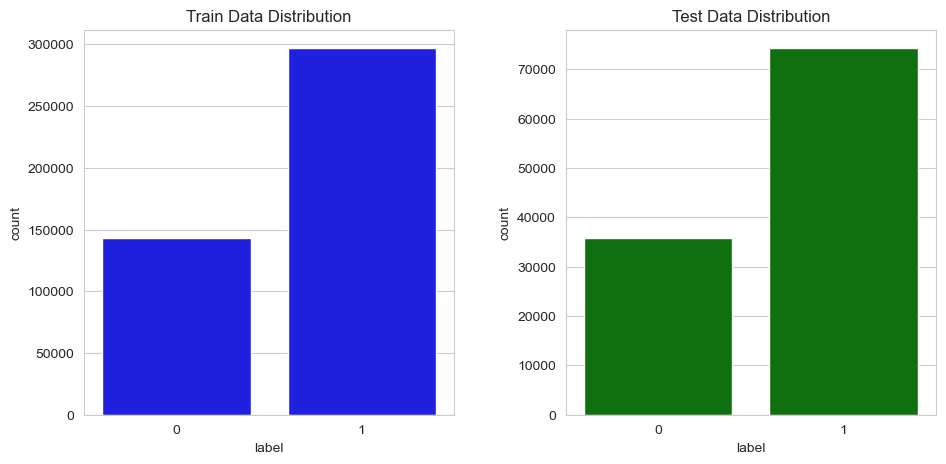

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

sns.countplot(data=df_train, x='label', color='blue', ax=axs[0])
axs[0].set_title('Train Data Distribution')

sns.countplot(data=df_test, x='label', color='green', ax=axs[1])
axs[1].set_title('Test Data Distribution')

fig.subplots_adjust(wspace=0.3)

plt.show()

While the data is not highly unbalanced in this case, it's still important to evaluate the label distribution in both the training and test sets. Additionally, a global control variable called `perform_undersampling` is provided in the notebook to apply under-sampling if needed.

In [ ]:
if perform_undersampling and not use_colab_gdrive:
    # Load RandomUnderSampler:
    try:
        from imblearn.under_sampling import RandomUnderSampler
    except:
        !pip install imblearn
        from imblearn.under_sampling import RandomUnderSampler

    # Perform undersampling using RandomUnderSampler
    rus = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train_array.reshape(-1, 1), y_train)

    # Convert the features and labels back to arrays
    X_train_array = X_train_resampled.flatten()
    y_train_array = y_train_resampled.flatten()

    df_train = pd.DataFrame({'text': X_train_array, 'label': y_train_array})

    # Plot the new distributions:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

    sns.countplot(data=df_train, x='label', color='blue', ax=axs[0])
    axs[0].set_title('Train Data Distribution')

    sns.countplot(data=df_test, x='label', color='green', ax=axs[1])
    axs[1].set_title('Test Data Distribution')

    fig.subplots_adjust(wspace=0.3)
    plt.show()

Finally, we extract all features using TF-IDF:

In [ ]:
# Apply TF-IDF and get the features:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,1), max_df=0.9))
])

# Fit and transform on train data:
X_train = pipe.fit_transform(X_train_array)

# Only transform on test data:
X_test = pipe.transform(X_test_array)

print("'{}' shape: {}".format('X_train', X_train.shape))
print("'{}' shape: {}".format('X_test', X_test.shape))

'X_train' shape: (440225, 98965)
'X_test' shape: (110057, 98965)


#### Save TfidfVectorizer:

In [ ]:
if not use_colab_gdrive:
  dump(pipe['tfidf'], 'tfidf.joblib')

### 1.3. Model Implementation:

Normally, we would split the training set into training and testing subsets using `train_test_split`. Then, we would apply `fit_transform` to the training set and use `transform` on the testing set. However, as we need to perform this process multiple times during cross-validation or hyper-parameter tuning, it is more efficient to use the `cross_validate` or `GridSearchCV` functions from `sklearn`. These functions handle the splitting of the data internally.

It's important to note that `cross_validate` or `GridSearchCV` do not perform TF-IDF. Therefore, we must set up a `Pipeline` to perform `fit_transform` on the training set and `transform` on the testing set within each fold. This ensures that the TF-IDF step is included in each iteration before passing the results to the classifier.

It's a good idea to perform cross-validation before moving to hyper-parameter tuning. This step allows us to evaluate how well each model performs and estimate the time required for a single training session using a set of hyper-parameters.

#### Import the needed libraries:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV

In [ ]:
if perform_RNN_training or perform_RNN_testing:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D, Bidirectional
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.optimizers import RMSprop
    from tensorflow.keras import backend as K
    from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
    from tensorflow.keras.models import save_model, load_model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, roc_auc_score
from matplotlib import colors

#### Define basic functions:

In [ ]:
# Function for cross-validation:
def cv_model(pipe):
    """
    Performs k-fold cross-validation and reports performance metrics.
    """

    if not perform_cv:
        return

    # Use cross_validate to get the cross-validated scores:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    cv_results = cross_validate(pipe, X_train, y_train, cv=skf, scoring=scoring)

    # Create a DataFrame object to store the results:
    cv_results_df = pd.DataFrame(cv_results)

    # Add a column for the fold number:
    fold_numbers = [i+1 for i in range(cv_results['test_accuracy'].size)]
    cv_results_df.insert(0, 'fold', fold_numbers)

    # Rename the columns to remove the "test_" prefix:
    cv_results_df.columns = [col.replace("test_", "") for col in cv_results_df.columns]

    # Add a row for the mean values:
    mean_values = cv_results_df.mean().to_dict()
    mean_values['fold'] = 'mean'
    mean_df = pd.DataFrame([mean_values])

    # Print the results as a table:
    cv_results_df = pd.concat([cv_results_df, mean_df], ignore_index=True).round(3)
    print(cv_results_df.to_markdown(index=False, tablefmt='fancy_outline', floatfmt='.3f'))

In [ ]:
if perform_RNN_training:
    # Enable GPUs:
    gpus = tf.config.list_physical_devices('GPU')

    if gpus:
        print("Available GPUs:")
        for gpu in gpus:
            print(gpu)

            # Enable dynamic memory allocation for all GPUs
            tf.config.experimental.set_memory_growth(gpu, True)
    else:
        print("GPU not available.")

In [ ]:
if perform_RNN_training or perform_RNN_testing:
    """
    Applies Tokenizer and pad_sequences.
    """

    class TokenizeAndPadSequences(BaseEstimator, TransformerMixin):
        def __init__(self, num_words=1000, maxlen=100):
            self.num_words = num_words
            self.maxlen = maxlen
            self.tokenizer = None

        def fit(self, X, y=None, num_words=None, maxlen=None):
            self.num_words = num_words or self.num_words
            self.maxlen = maxlen or self.maxlen
            self.tokenizer = Tokenizer(num_words=self.num_words)
            self.tokenizer.fit_on_texts(X)
            return self

        def transform(self, X, y=None):
            sequences = self.tokenizer.texts_to_sequences(X)
            padded_sequences = pad_sequences(sequences, maxlen=self.maxlen)
            return padded_sequences

In [ ]:
if perform_RNN_training or perform_RNN_testing:
    def f1_macro(y_true, y_pred):
        """
        Returns macro averaged f1-score.
        """

        # Convert probabilities to class labels:
        y_pred_labels = K.cast(y_pred > 0.5, dtype='float32')

        # Compute F1-score for class 0:
        tp_class0 = K.sum(y_true[y_true == 0] * y_pred_labels[y_true == 0])
        fn_class0 = K.sum((1 - y_true[y_true == 0]) * y_pred_labels[y_true == 0])
        fp_class0 = K.sum(y_true[y_true == 0] * (1 - y_pred_labels[y_true == 0]))
        f1_class0 = 2 * tp_class0 / (2 * tp_class0 + fn_class0 + fp_class0 + K.epsilon())

        # Compute F1-score for class 1:
        tp_class1 = K.sum(y_true[y_true == 1] * y_pred_labels[y_true == 1])
        fn_class1 = K.sum((1 - y_true[y_true == 1]) * y_pred_labels[y_true == 1])
        fp_class1 = K.sum(y_true[y_true == 1] * (1 - y_pred_labels[y_true == 1]))
        f1_class1 = 2 * tp_class1 / (2 * tp_class1 + fn_class1 + fp_class1 + K.epsilon())

        # Compute average F1-score:
        f1_macro = (f1_class0 + f1_class1) / 2
        return f1_macro

#### Logistic Regression:

In [ ]:
# Set up the pipeline:
pipe = Pipeline([
    ('lr', LogisticRegression(max_iter=10000))
])

# Cross-validate model:
cv_model(pipe)

╒════════╤════════════╤══════════════╤════════════╤═══════════════════╤════════════════╤════════════╕
│ fold   │   fit_time │   score_time │   accuracy │   precision_macro │   recall_macro │   f1_macro │
╞════════╪════════════╪══════════════╪════════════╪═══════════════════╪════════════════╪════════════╡
│ 1      │      8.976 │        0.102 │      0.975 │             0.971 │          0.972 │      0.971 │
│ 2      │     10.759 │        0.092 │      0.975 │             0.971 │          0.971 │      0.971 │
│ 3      │      9.444 │        0.101 │      0.974 │             0.970 │          0.971 │      0.971 │
│ 4      │      8.344 │        0.090 │      0.975 │             0.971 │          0.971 │      0.971 │
│ 5      │     10.913 │        0.085 │      0.975 │             0.971 │          0.971 │      0.971 │
│ mean   │      9.687 │        0.094 │      0.975 │             0.971 │          0.971 │      0.971 │
╘════════╧════════════╧══════════════╧════════════╧═══════════════════╧═══════════

#### Naive Bayes:

GaussianNB and MultinomialNB are both variants of the Naive Bayes algorithm used for classification tasks. However, they differ in their assumptions about the distribution of the input features.

GaussianNB assumes that the input features follow a Gaussian (normal) distribution. This means that the features are continuous and can take on any real value. GaussianNB is often used for problems where the features have a continuous distribution, such as in image recognition or speech recognition.

MultinomialNB, on the other hand, assumes that the input features follow a multinomial distribution. This means that the features represent counts or frequencies of occurrences, such as word frequencies in a text document. MultinomialNB is often used in natural language processing tasks such as text classification or spam detection.

In [ ]:
# Set up the pipeline:
pipe = Pipeline([
    ('nb', MultinomialNB())
])

# Cross-validate model:
cv_model(pipe)

╒════════╤════════════╤══════════════╤════════════╤═══════════════════╤════════════════╤════════════╕
│ fold   │   fit_time │   score_time │   accuracy │   precision_macro │   recall_macro │   f1_macro │
╞════════╪════════════╪══════════════╪════════════╪═══════════════════╪════════════════╪════════════╡
│ 1      │      0.088 │        0.079 │      0.929 │             0.938 │          0.900 │      0.916 │
│ 2      │      0.090 │        0.080 │      0.929 │             0.938 │          0.900 │      0.916 │
│ 3      │      0.083 │        0.078 │      0.929 │             0.937 │          0.900 │      0.915 │
│ 4      │      0.080 │        0.080 │      0.928 │             0.938 │          0.899 │      0.915 │
│ 5      │      0.080 │        0.080 │      0.930 │             0.939 │          0.901 │      0.917 │
│ mean   │      0.084 │        0.079 │      0.929 │             0.938 │          0.900 │      0.916 │
╘════════╧════════════╧══════════════╧════════════╧═══════════════════╧═══════════

#### SVM:

In [ ]:
# Set up the pipeline:
pipe = Pipeline([
    ('svm', LinearSVC(random_state=42))
])

# Cross-validate model:
cv_model(pipe)

╒════════╤════════════╤══════════════╤════════════╤═══════════════════╤════════════════╤════════════╕
│ fold   │   fit_time │   score_time │   accuracy │   precision_macro │   recall_macro │   f1_macro │
╞════════╪════════════╪══════════════╪════════════╪═══════════════════╪════════════════╪════════════╡
│ 1      │      1.659 │        0.071 │      0.977 │             0.973 │          0.974 │      0.973 │
│ 2      │      1.642 │        0.080 │      0.976 │             0.972 │          0.973 │      0.973 │
│ 3      │      1.691 │        0.094 │      0.976 │             0.972 │          0.973 │      0.972 │
│ 4      │      1.674 │        0.082 │      0.977 │             0.973 │          0.974 │      0.974 │
│ 5      │      1.712 │        0.084 │      0.976 │             0.973 │          0.973 │      0.973 │
│ mean   │      1.675 │        0.082 │      0.976 │             0.973 │          0.973 │      0.973 │
╘════════╧════════════╧══════════════╧════════════╧═══════════════════╧═══════════

#### Decision-Tree:

In [ ]:
# Set up the pipeline
pipe = Pipeline([
    ('dt', DecisionTreeClassifier(max_depth=10, random_state=42))
])

# Cross-validate model:
cv_model(pipe)

╒════════╤════════════╤══════════════╤════════════╤═══════════════════╤════════════════╤════════════╕
│ fold   │   fit_time │   score_time │   accuracy │   precision_macro │   recall_macro │   f1_macro │
╞════════╪════════════╪══════════════╪════════════╪═══════════════════╪════════════════╪════════════╡
│ 1      │    100.712 │        0.131 │      0.923 │             0.905 │          0.933 │      0.916 │
│ 2      │     85.735 │        0.123 │      0.923 │             0.904 │          0.932 │      0.915 │
│ 3      │    100.024 │        0.130 │      0.923 │             0.904 │          0.932 │      0.915 │
│ 4      │     88.548 │        0.126 │      0.923 │             0.905 │          0.932 │      0.915 │
│ 5      │    109.240 │        0.139 │      0.923 │             0.904 │          0.932 │      0.915 │
│ mean   │     96.852 │        0.130 │      0.923 │             0.904 │          0.932 │      0.915 │
╘════════╧════════════╧══════════════╧════════════╧═══════════════════╧═══════════

#### Deep Learning with RNN:

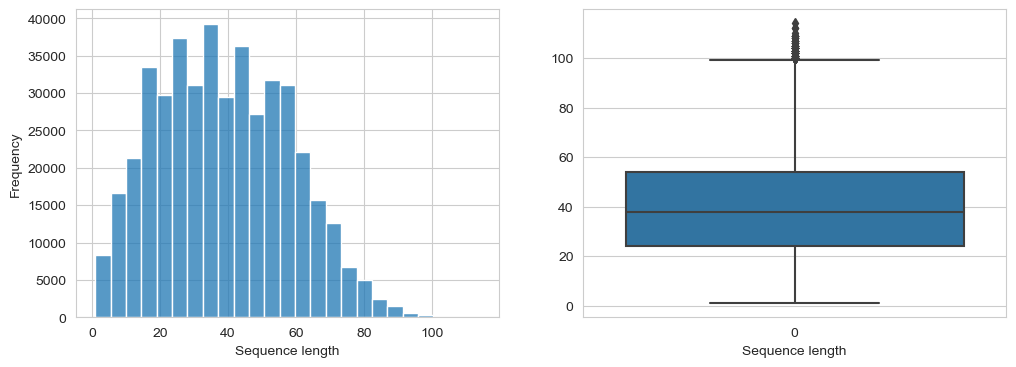

In [ ]:
# Compute the lengths of each sequence:
sequence_lengths = [len(seq) for seq in X_train_array]

# Set up the figure and axes:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

# Plot the histogram on the first axis:
sns.histplot(sequence_lengths, bins=25, ax=axs[0])
axs[0].set_xlabel('Sequence length')
axs[0].set_ylabel('Frequency')

# Plot the box plot on the second axis:
sns.boxplot(sequence_lengths, ax=axs[1])
axs[1].set_xlabel('Sequence length')

# Show the plots:
plt.show()

In [ ]:
print(f"Maximum sequence length: {max([len(text) for text in X_train_array])}")

Maximum sequence length: 114


As the top whisker is at 100, we chose 100 for the value of `maxlen`.

In [ ]:
if perform_RNN_training:
    # Set hyperparameters:
    max_words = 10000
    maxlen = 100
    output_dim = 100
    batch_size = 32
    validation_split = 0.2
    epochs = 10
    optimizer = RMSprop(learning_rate=0.01)

    # Set random seed:
    np.random.seed(42)

    # Define model architecture:
    RNN = Sequential()
    RNN.add(Embedding(input_dim=max_words, output_dim=output_dim, input_length=maxlen))
    RNN.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
    RNN.add(Dense(units=1, activation='sigmoid'))

    # Print model summary:
    RNN.summary()

    # Compile model:
    RNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[f1_macro])

    # Set up the pipeline:
    pipe = Pipeline([
        ('preprocess', TokenizeAndPadSequences()),
        ('rnn', RNN)
    ])

    # Set up the hyperparameters:
    hp = {
        'preprocess__num_words': max_words,
        'preprocess__maxlen': maxlen,
        'rnn__batch_size': batch_size,
        'rnn__validation_split': validation_split,
        'rnn__epochs': 10
    }

    # Fit the pipeline to the data:
    pipe.fit(X_train_array, y_train, **hp)

    # Save the trained model:
    dump(pipe['preprocess'], 'RNN.joblib')
    save_model(pipe['rnn'], 'RNN.h5')

### 1.4. Hyper-parameter Tuning:

#### Define basic functions:

In [ ]:
# Define dictionary to save models:
models_dict = {}

In [ ]:
def tune_model(pipe, param_grid):
    """
    Performs hyper-parameter tuning and reports performance metrics.
    """

    if not perform_tuning:
        return

    # Perform grid search with cross-validation:
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

    # Select best model based on average f1-score:
    grid_search = GridSearchCV(pipe, param_grid, cv=skf, scoring=scoring, return_train_score=True, refit='f1_macro', verbose=1)
    grid_search.fit(X_train, y_train)

    # Get the results as a DataFrame
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Filter the results to include only the best set of parameters:
    best_results = results_df[results_df.params == grid_search.best_params_]

    # Reshape values into a table:
    columns = ["split{}_test_".format(i) + metric for i in range(5) for metric in scoring]
    table = best_results[columns].values.reshape(5, len(scoring))
    columns = ["mean_test_" + metric for metric in scoring]
    mean_values = best_results[columns].values
    table = np.append(table, mean_values, axis=0)

    # Create a new DataFrame with the reshaped values:
    best_results_df = pd.DataFrame(table, columns=scoring)

    # Add a column for the fold number:
    fold_numbers = [str(i+1) for i in range(n_splits)] + ['mean']
    best_results_df.insert(0, 'fold', fold_numbers)

    # Print the results as a table:
    print(best_results_df.to_markdown(index=False, tablefmt='fancy_outline', floatfmt='.3f'))
    print(f"mean_fit_time: {best_results.mean_fit_time.iloc[0]:.3f}")
    print(f"mean_score_time: {best_results.mean_score_time.iloc[0]:.3f}\n")
    print("Best set of hyper-parameters:")
    print(grid_search.best_params_)

    return grid_search.best_estimator_

#### Logistic Regression:

In [ ]:
# Set up the pipeline:
pipe = Pipeline([
    ('lr', LogisticRegression(max_iter=10000))
])

# Set up the parameter grid to search over:
param_grid = {
    'lr__C': [1, 10, 100],
    'lr__fit_intercept': [True, False],
    'lr__solver': ['lbfgs', 'liblinear']
}

# Save the best model with a unique identifier:
models_dict['lr'] = tune_model(pipe, param_grid)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
╒════════╤════════════╤═══════════════════╤════════════════╤════════════╕
│ fold   │   accuracy │   precision_macro │   recall_macro │   f1_macro │
╞════════╪════════════╪═══════════════════╪════════════════╪════════════╡
│ 1      │      0.977 │             0.974 │          0.974 │      0.974 │
│ 2      │      0.977 │             0.973 │          0.973 │      0.973 │
│ 3      │      0.976 │             0.973 │          0.973 │      0.973 │
│ 4      │      0.977 │             0.974 │          0.974 │      0.974 │
│ 5      │      0.977 │             0.974 │          0.973 │      0.974 │
│ mean   │      0.977 │             0.974 │          0.973 │      0.973 │
╘════════╧════════════╧═══════════════════╧════════════════╧════════════╛
mean_fit_time: 5.351
mean_score_time: 0.094

Best set of hyper-parameters:
{'lr__C': 10, 'lr__fit_intercept': False, 'lr__solver': 'lbfgs'}


#### Naive Bayes:

In [ ]:
# Set up the pipeline:
pipe = Pipeline([
    ('nb', MultinomialNB())
])

# Set up the parameter grid to search over:
param_grid = {
    'nb__alpha': [0.1, 1, 10],
    'nb__fit_prior': [True, False]
}

# Save the best model with a unique identifier:
models_dict['nb'] = tune_model(pipe, param_grid)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
╒════════╤════════════╤═══════════════════╤════════════════╤════════════╕
│ fold   │   accuracy │   precision_macro │   recall_macro │   f1_macro │
╞════════╪════════════╪═══════════════════╪════════════════╪════════════╡
│ 1      │      0.942 │             0.930 │          0.940 │      0.935 │
│ 2      │      0.943 │             0.931 │          0.941 │      0.935 │
│ 3      │      0.940 │             0.928 │          0.939 │      0.933 │
│ 4      │      0.942 │             0.930 │          0.941 │      0.935 │
│ 5      │      0.942 │             0.929 │          0.940 │      0.934 │
│ mean   │      0.942 │             0.930 │          0.940 │      0.935 │
╘════════╧════════════╧═══════════════════╧════════════════╧════════════╛
mean_fit_time: 0.088
mean_score_time: 0.092

Best set of hyper-parameters:
{'nb__alpha': 1, 'nb__fit_prior': False}


#### SVM:

In [ ]:
# Set up the pipeline:
pipe = Pipeline([
    ('svm', LinearSVC(max_iter=10000, random_state=42))
])

# Set up the parameter grid to search over:
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__fit_intercept': [True, False],
    'svm__dual': [True, False]
}

# Save the best model with a unique identifier:
models_dict['svm'] = tune_model(pipe, param_grid)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
╒════════╤════════════╤═══════════════════╤════════════════╤════════════╕
│ fold   │   accuracy │   precision_macro │   recall_macro │   f1_macro │
╞════════╪════════════╪═══════════════════╪════════════════╪════════════╡
│ 1      │      0.977 │             0.973 │          0.973 │      0.973 │
│ 2      │      0.976 │             0.973 │          0.973 │      0.973 │
│ 3      │      0.976 │             0.973 │          0.973 │      0.973 │
│ 4      │      0.977 │             0.974 │          0.973 │      0.974 │
│ 5      │      0.976 │             0.973 │          0.973 │      0.973 │
│ mean   │      0.976 │             0.973 │          0.973 │      0.973 │
╘════════╧════════════╧═══════════════════╧════════════════╧════════════╛
mean_fit_time: 1.415
mean_score_time: 0.093

Best set of hyper-parameters:
{'svm__C': 1, 'svm__dual': True, 'svm__fit_intercept': False}


#### Decision-Tree:

In [ ]:
# Set up the pipeline:
pipe = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Set up the parameter grid to search over:
param_grid = {
    'dt__max_depth': [10, 100],
    'dt__min_samples_split': [10, 20],
    'dt__min_samples_leaf': [5, 10]
}

# Save the best model with a unique identifier:
models_dict['dt'] = tune_model(pipe, param_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
╒════════╤════════════╤═══════════════════╤════════════════╤════════════╕
│ fold   │   accuracy │   precision_macro │   recall_macro │   f1_macro │
╞════════╪════════════╪═══════════════════╪════════════════╪════════════╡
│ 1      │      0.921 │             0.902 │          0.931 │      0.913 │
│ 2      │      0.921 │             0.902 │          0.930 │      0.913 │
│ 3      │      0.921 │             0.903 │          0.930 │      0.914 │
│ 4      │      0.921 │             0.903 │          0.930 │      0.914 │
│ 5      │      0.921 │             0.903 │          0.931 │      0.914 │
│ mean   │      0.921 │             0.903 │          0.930 │      0.913 │
╘════════╧════════════╧═══════════════════╧════════════════╧════════════╛
mean_fit_time: 103.878
mean_score_time: 0.137

Best set of hyper-parameters:
{'dt__max_depth': 100, 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 20}


#### Save tuned models:

In [ ]:
if not use_colab_gdrive:
  url = "tuned_models.joblib"
  if perform_tuning:
      # Remove 'rnn' from dictionary:
      if 'rnn' in models_dict:
          models_dict.pop('rnn')

      dump(models_dict, url)

### 1.5. Model Testing:

#### Load hyper-parameter tuned models:

In [ ]:
if not use_colab_gdrive:
    url = "tuned_models.joblib"
    models_dict = load(url)
else:
    url = "https://drive.google.com/file/d/1UQjqxdJE7o3IDUYrduVrDIArLfXwDBCd/view?usp=share_link"

    # Extract file ID from URL:
    file_id = url.split('/')[-2]

    # Set destination file path and name:
    destination = "tuned_models.joblib"

    # Download file from Google Drive:
    response = requests.get(f"https://drive.google.com/uc?id={file_id}")
    content = response.content

    # Save file locally:
    with open(destination, 'wb') as f:
        f.write(content)

    # Load file:
    models_dict = load(destination)

#### Define basic functions:

In [ ]:
def print_classification_report(y_true, y_pred):
    """
    Formats classification report.
    """
    # Classification report dictionary:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame.from_dict(report_dict)

    # Insert empty row above 'accuracy':
    report_df.insert(loc=2, column='', value=[None]*report_df.shape[0])
    report_df = report_df.transpose()

    # Convert support values to strings:
    report_df.loc['accuracy', 'support'] = report_df.loc['0', 'support'] + report_df.loc['1', 'support']
    report_df.loc['', 'support'] = 0
    report_df['support'] = report_df['support'].astype('int').astype('str')
    report_df.loc['', 'support'] = ''

    # Print the results as a table:
    print(report_df.to_markdown(tablefmt='fancy_outline', floatfmt='.3f'))
    return report_dict

In [ ]:
# Define dictionary to save scores:
scores_dict = {}

def test_model(args):
    """
    Tests model on held-out test data and reports performance metrics.
    """

    if not perform_testing:
        return

    # Extract model attributes:
    model_name = args['model_name']
    y_train_pred = args['y_train_pred']
    y_test_pred = args['y_test_pred']

    # Classification report for train set:
    print(f"Train set classification report for '{model_name}':")
    report_dict = print_classification_report(y_train, y_train_pred)
    print('')

    # Store all scores for train set:
    train_auc = roc_auc_score(y_train, y_train_pred)
    train_scores = pd.DataFrame(metric_scores(report_dict, train_auc), index=['train'])

    # Classification report for test set:
    print(f"Test set classification report for '{model_name}':")
    report_dict = print_classification_report(y_test, y_test_pred)
    print('')

    # Store all scores for test set:
    test_auc = roc_auc_score(y_test, y_test_pred)
    test_scores = pd.DataFrame(metric_scores(report_dict, test_auc), index=['test'])

    # Concatenate train and test score DataFrames vertically:
    scores_df = pd.concat([train_scores, test_scores])

    return scores_df

In [ ]:
def metric_scores(report_dict, auc):
    """
    Returns a dictionary containing all performance metrics.
    """

    metrics_dict = {
        'Precision': report_dict['macro avg']['precision'],
        'Recall': report_dict['macro avg']['recall'],
        'F1': report_dict['macro avg']['f1-score'],
        'Accuracy': report_dict['accuracy'],
        'AUC': auc
    }

    return metrics_dict

In [ ]:
def format_quantile(ax, cm):
    """
    Formats the quantiles on confusion matrix plot.
    """

    # Add annotations for TN, FP, FN, TP:
    names = [['TN','FP'], ['FN', 'TP']]

    # Define the normalization object using the minimum and maximum values:
    norm = colors.Normalize(vmin=np.min(cm), vmax=np.max(cm))

    # Use the normalization object to get the color of the text for each value:
    for i in range(len(cm)):
        for j in range(len(cm)):
            color = 'white' if norm(cm[i, j]) > 0.8 or norm(cm[i, j]) < 0.2 else 'black'
            ax.text(j+0.5, i+0.5, f"{names[i][j]} = {cm[i][j]}", ha='center', va='center', color=color)

In [ ]:
def plot_cm(args):
    """
    Plots heatmaps of confusion matrices for train and test sets.
    """

    if not perform_testing:
        return

    # Extract model attributes:
    model_name = args['model_name']
    y_train_pred = args['y_train_pred']
    y_test_pred = args['y_test_pred']

    # Create the confusion matrix for train set:
    cm_train = confusion_matrix(y_train, y_train_pred)

    # Create the confusion matrix for test set:
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Create the subplots:
    fig, axs = plt.subplots(1, 2, figsize=(11, 4))

    # Plot the confusion matrix for train set:
    sns.heatmap(cm_train, annot=False, cmap='RdYlGn', fmt='g', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axs[0])
    axs[0].set_xlabel('Predicted labels')
    axs[0].set_ylabel('True labels')
    axs[0].set_title('Confusion Matrix (Train Set)')
    format_quantile(axs[0], cm_train)

    # Plot the confusion matrix for test set:
    sns.heatmap(cm_test, annot=False, cmap='RdYlGn', fmt='g', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axs[1])
    axs[1].set_xlabel('Predicted labels')
    axs[1].set_ylabel('True labels')
    axs[1].set_title('Confusion Matrix (Test Set)')
    format_quantile(axs[1], cm_test)

    # Adjust the spacing between the subplots:
    plt.subplots_adjust(wspace=0.25)

    # Display the plot:
    plt.show()

In [ ]:
def plot_roc(args):
    """
    Plots ROC curve for train and test sets.
    """

    if not perform_testing:
        return

    # Extract model attributes:
    model_name = args['model_name']
    model = args['model']

    # Change input type for RNN:
    if model_name == 'rnn':
        x_train = X_train_array
        x_test = X_test_array
    else:
        x_train = X_train
        x_test = X_test

    # Create the subplots:
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Generate the ROC curve for the train set:
    RocCurveDisplay.from_estimator(model, x_train, y_train, ax=axs[0], name=model_name, color='tab:blue')

    # Generate the ROC curve for the test set:
    RocCurveDisplay.from_estimator(model, x_test, y_test, ax=axs[1], name=model_name, color='tab:orange')

    # Add titles and axis labels to the subplots:
    axs[0].set_title('ROC Curve - Train Set')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')

    axs[1].set_title('ROC Curve - Test Set')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')

    # Adjust the spacing between the subplots:
    plt.subplots_adjust(wspace=0.3)

    # Display the plot:
    plt.show()

In [ ]:
if perform_RNN_testing:
    class BinaryModel(ClassifierMixin):
        """
        Converts the RNN model to a binary classifier.
        """

        def __init__(self, original_model):
            super(BinaryModel, self).__init__()
            self.original_model = original_model
            self.classes_ = [0, 1]

        def call(self, inputs):
            return self.original_model(inputs)

        def predict(self, x, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10,
                    workers=1, use_multiprocessing=False):
            preds_binary = np.where(self.original_model.predict(x, batch_size=batch_size, verbose=verbose, steps=steps,
                                                                callbacks=callbacks, max_queue_size=max_queue_size, workers=workers,
                                                                use_multiprocessing=use_multiprocessing).flatten() > 0.5, 1, 0)
            return preds_binary

        def predict_proba(self, x, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10,
                          workers=1, use_multiprocessing=False):
            preds_prob = self.original_model.predict(x, batch_size=batch_size, verbose=verbose, steps=steps,
                                                     callbacks=callbacks, max_queue_size=max_queue_size, workers=workers,
                                                     use_multiprocessing=use_multiprocessing)
            return np.hstack((1 - preds_prob, preds_prob))

#### Logistic Regression:

Train set classification report for 'lr':
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │       0.981 │    0.981 │      0.981 │ 143247    │
│ 1            │       0.991 │    0.991 │      0.991 │ 296978    │
│              │             │          │            │           │
│ accuracy     │       0.988 │    0.988 │      0.988 │ 440225    │
│ macro avg    │       0.986 │    0.986 │      0.986 │ 440225    │
│ weighted avg │       0.988 │    0.988 │      0.988 │ 440225    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛

Test set classification report for 'lr':
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │       0.965 │    0.964 │    

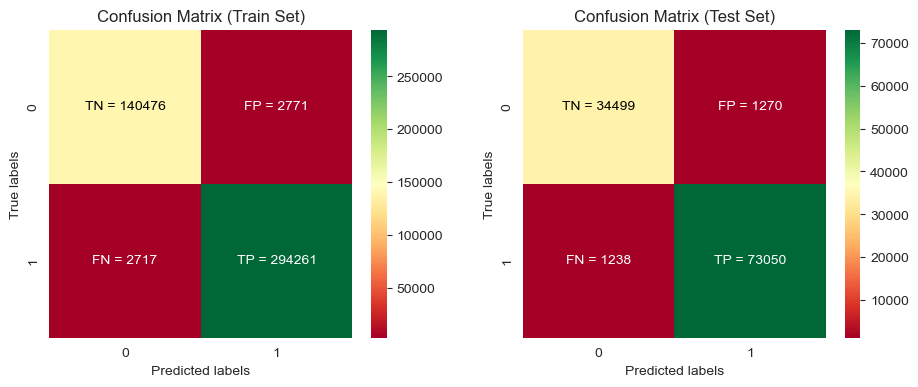

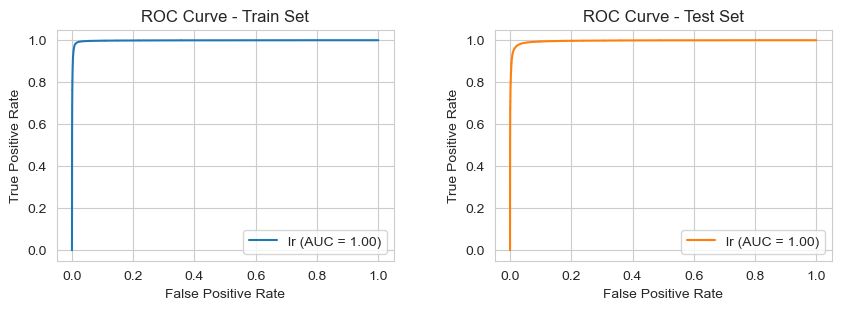

In [ ]:
# Load model:
model_name = 'lr'
model = models_dict[model_name]

# Define dictionary for arguments:
args = {
    'model_name': model_name,
    'model': models_dict[model_name],
    'y_train_pred': model.predict(X_train),
    'y_test_pred': model.predict(X_test)
}

# Test model on traning and test sets:
scores_df = test_model(args)

# Heatmap for confusion matrix:
print('')
plot_cm(args)


# Plot the ROC curve:
print('')
plot_roc(args)

# Save scores with a unique identifier:
scores_dict[model_name] = scores_df.transpose().to_dict()

#### Naive Bayes:

Train set classification report for 'nb':
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │       0.910 │    0.950 │      0.930 │ 143247    │
│ 1            │       0.976 │    0.954 │      0.965 │ 296978    │
│              │             │          │            │           │
│ accuracy     │       0.953 │    0.953 │      0.953 │ 440225    │
│ macro avg    │       0.943 │    0.952 │      0.947 │ 440225    │
│ weighted avg │       0.954 │    0.953 │      0.953 │ 440225    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛

Test set classification report for 'nb':
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │       0.899 │    0.936 │    

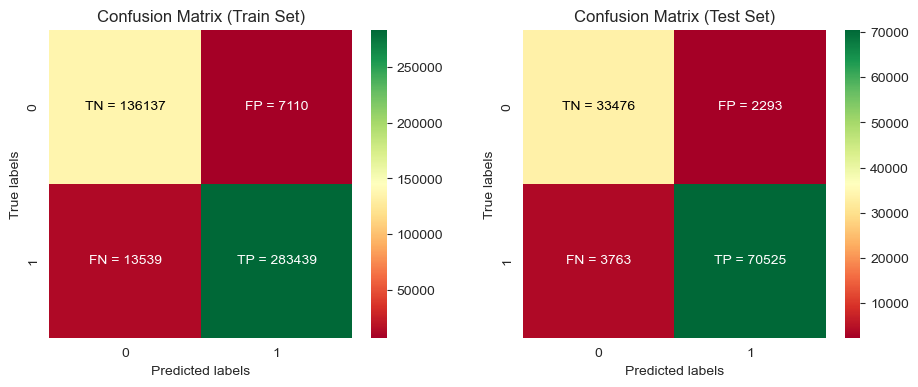

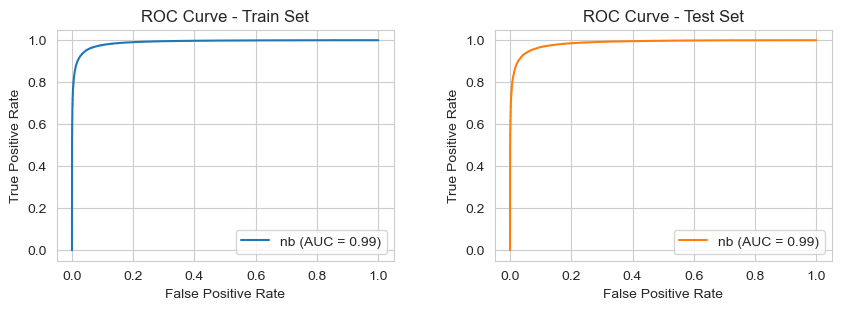

In [ ]:
# Load model:
model_name = 'nb'
model = models_dict[model_name]

# Define dictionary for arguments:
args = {
    'model_name': model_name,
    'model': models_dict[model_name],
    'y_train_pred': model.predict(X_train),
    'y_test_pred': model.predict(X_test)
}

# Test model on traning and test sets:
scores_df = test_model(args)

# Heatmap for confusion matrix:
print('')
plot_cm(args)


# Plot the ROC curve:
print('')
plot_roc(args)

# Save scores with a unique identifier:
scores_dict[model_name] = scores_df.transpose().to_dict()

#### SVM:

Train set classification report for 'svm':
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │       0.981 │    0.981 │      0.981 │ 143247    │
│ 1            │       0.991 │    0.991 │      0.991 │ 296978    │
│              │             │          │            │           │
│ accuracy     │       0.988 │    0.988 │      0.988 │ 440225    │
│ macro avg    │       0.986 │    0.986 │      0.986 │ 440225    │
│ weighted avg │       0.988 │    0.988 │      0.988 │ 440225    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛

Test set classification report for 'svm':
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │       0.964 │    0.965 │  

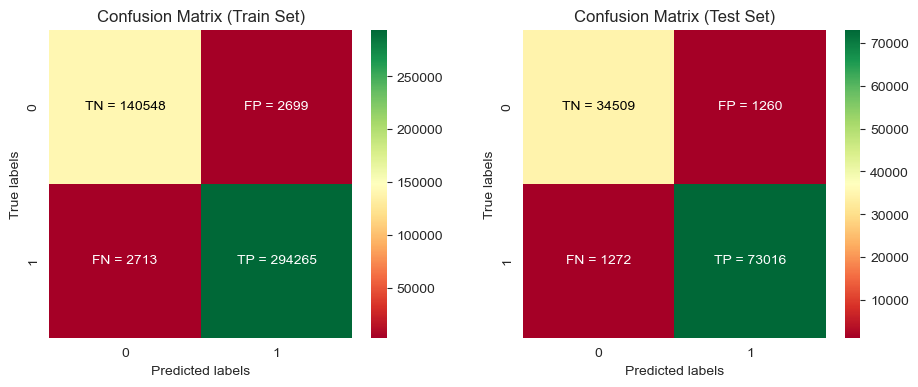

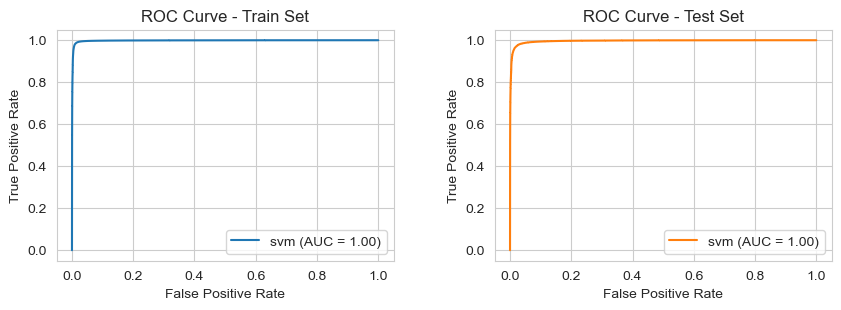

In [ ]:
# Load model:
model_name = 'svm'
model = models_dict[model_name]

# Define dictionary for arguments:
args = {
    'model_name': model_name,
    'model': models_dict[model_name],
    'y_train_pred': model.predict(X_train),
    'y_test_pred': model.predict(X_test)
}

# Test model on traning and test sets:
scores_df = test_model(args)

# Heatmap for confusion matrix:
print('')
plot_cm(args)


# Plot the ROC curve:
print('')
plot_roc(args)

# Save scores with a unique identifier:
scores_dict[model_name] = scores_df.transpose().to_dict()

#### Decision-Tree:

Train set classification report for 'dt':
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │       0.839 │    0.967 │      0.898 │ 143247    │
│ 1            │       0.983 │    0.910 │      0.945 │ 296978    │
│              │             │          │            │           │
│ accuracy     │       0.929 │    0.929 │      0.929 │ 440225    │
│ macro avg    │       0.911 │    0.939 │      0.922 │ 440225    │
│ weighted avg │       0.936 │    0.929 │      0.930 │ 440225    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛

Test set classification report for 'dt':
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │       0.828 │    0.954 │    

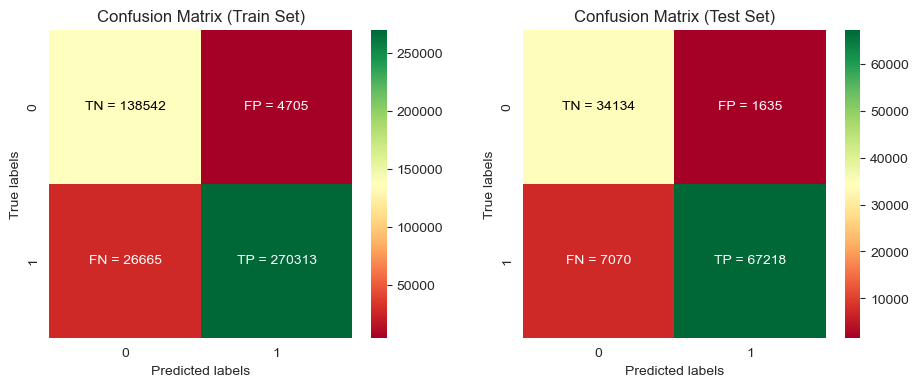

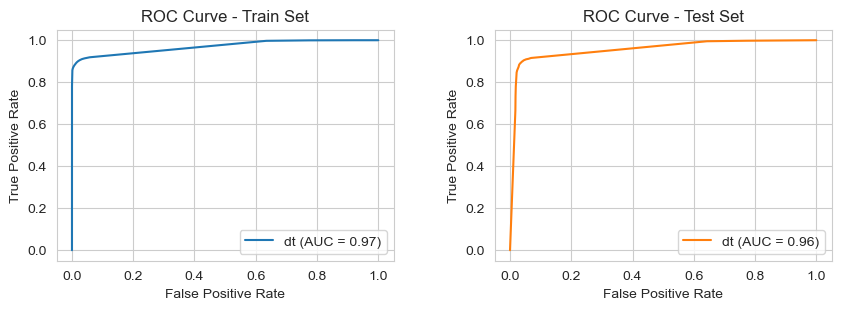

In [ ]:
# Load model:
model_name = 'dt'
model = models_dict[model_name]

# Define dictionary for arguments:
args = {
    'model_name': model_name,
    'model': models_dict[model_name],
    'y_train_pred': model.predict(X_train),
    'y_test_pred': model.predict(X_test)
}

# Test model on traning and test sets:
scores_df = test_model(args)

# Heatmap for confusion matrix:
print('')
plot_cm(args)


# Plot the ROC curve:
print('')
plot_roc(args)

# Save scores with a unique identifier:
scores_dict[model_name] = scores_df.transpose().to_dict()

#### RNN:

In [ ]:
# Load RNN model separately:
if not use_colab_gdrive:
    steps = [('preprocess', load('RNN.joblib')),
              ('rnn', load_model('RNN.h5', custom_objects={'f1_macro': f1_macro}))]
    models_dict['rnn'] = Pipeline(steps)
    model_name = 'rnn'
    model = BinaryModel(models_dict[model_name])
else:
    # Set the URL for "RNN.joblib" file:
    url_joblib = "https://drive.google.com/file/d/1CZ_s9oxs1hKogpuv63rMNwYM8rZrJNXL/view?usp=share_link"
    file_id_joblib = url_joblib.split('/')[-2]
    destination_joblib = "RNN.joblib"

    # Download file from Google Drive:
    response_joblib = requests.get(f"https://drive.google.com/uc?id={file_id_joblib}")
    content_joblib = response_joblib.content

    # Save file locally:
    with open(destination_joblib, 'wb') as f:
        f.write(content_joblib)

    # Set the URL for "RNN.h5" file:
    url_h5 = "https://drive.google.com/file/d/1es361pwxj7cLz6jYY2NTEKEsQWdeC9di/view?usp=share_link"
    file_id_h5 = url_h5.split('/')[-2]
    destination_h5 = "RNN.h5"

    # Download file from Google Drive:
    response_h5 = requests.get(f"https://drive.google.com/uc?id={file_id_h5}")
    content_h5 = response_h5.content
    # Save file locally:
    with open(destination_h5, 'wb') as f:
        f.write(content_h5)

    # Load RNN model:
    steps = [('preprocess', load(destination_joblib)),
              ('rnn', load_model(destination_h5, custom_objects={'f1_macro': f1_macro}))]
    models_dict['rnn'] = Pipeline(steps)
    model_name = 'rnn'
    model = BinaryModel(models_dict[model_name])

3440/3440 [==============================] - 304s 89ms/step

Train set classification report for 'rnn':
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │       0.972 │    0.966 │      0.969 │ 143247    │
│ 1            │       0.984 │    0.987 │      0.985 │ 296978    │
│              │             │          │            │           │
│ accuracy     │       0.980 │    0.980 │      0.980 │ 440225    │
│ macro avg    │       0.978 │    0.976 │      0.977 │ 440225    │
│ weighted avg │       0.980 │    0.980 │      0.980 │ 440225    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛

Test set classification report for 'rnn':
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════

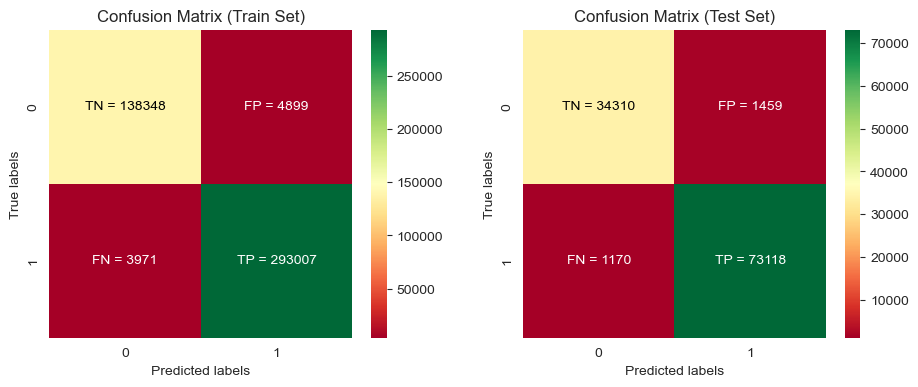

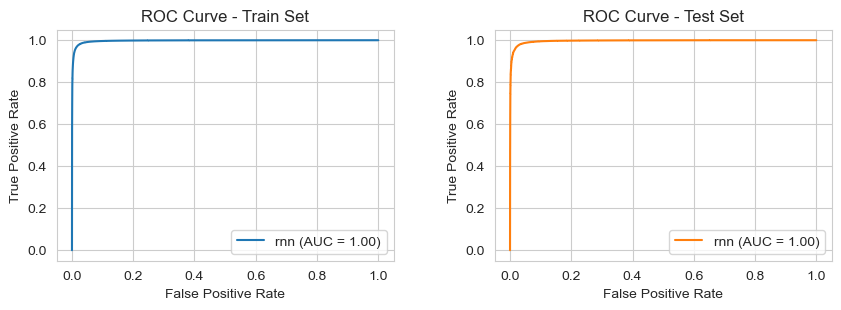

In [ ]:
if perform_RNN_testing:
    # Define dictionary for arguments:
    args = {
        'model_name': model_name,
        'model': model,
        'y_train_pred': model.predict(X_train_array, verbose=1),
        'y_test_pred': model.predict(X_test_array, verbose=1)
    }

    # Test model on traning and test sets:
    print('')
    scores_df = test_model(args)

    # Heatmap for confusion matrix:
    print('')
    plot_cm(args)

    # Plot the ROC curve:
    print('')
    plot_roc(args)

    # Save scores with a unique identifier:
    scores_dict[model_name] = scores_df.transpose().to_dict()

#### Save scores:

In [ ]:
if not use_colab_gdrive:
  url = "model_scores.joblib"
  if perform_testing:
      dump(scores_dict, url)

### 1.6. Model Comparison and Selection

In [ ]:
if not use_colab_gdrive:
    # Load train and test scores:
    url = "model_scores.joblib"
    scores_dict = load(url)
else:
    url = "https://drive.google.com/file/d/1afPzgHj3tOI_QvxGD2mTSRudR3cqhQnF/view?usp=share_link"

    # Extract file ID from URL:
    file_id = url.split('/')[-2]

    # Set destination file path and name:
    destination = "model_scores.joblib"

    # Download file from Google Drive:
    response = requests.get(f"https://drive.google.com/uc?id={file_id}")
    content = response.content

    # Save file locally:
    with open(destination, 'wb') as f:
        f.write(content)

    # Load file:
    scores_dict = load(destination)

In [ ]:
# Print all scores during training with best hyper-parameters:
train_scores = [scores_dict[model]['train'] for model in scores_dict.keys()]
scores_df = pd.DataFrame(train_scores, index=scores_dict.keys())
print("Train set metrics for all models:")
print(scores_df.to_markdown(tablefmt='fancy_outline', floatfmt='.3f'))

Train set metrics for all models:
╒═════╤═════════════╤══════════╤═══════╤════════════╤═══════╕
│     │   Precision │   Recall │    F1 │   Accuracy │   AUC │
╞═════╪═════════════╪══════════╪═══════╪════════════╪═══════╡
│ lr  │       0.986 │    0.986 │ 0.986 │      0.988 │ 0.986 │
│ nb  │       0.943 │    0.952 │ 0.947 │      0.953 │ 0.952 │
│ svm │       0.986 │    0.986 │ 0.986 │      0.988 │ 0.986 │
│ dt  │       0.911 │    0.939 │ 0.922 │      0.929 │ 0.939 │
│ rnn │       0.978 │    0.976 │ 0.977 │      0.980 │ 0.976 │
╘═════╧═════════════╧══════════╧═══════╧════════════╧═══════╛


In [ ]:
# Print all scores during testing with best hyper-parameters:
test_scores = [scores_dict[model]['test'] for model in scores_dict.keys()]
scores_df = pd.DataFrame(test_scores, index=scores_dict.keys())
print("Test set metrics for all models:")
print(scores_df.to_markdown(tablefmt='fancy_outline', floatfmt='.3f'))

Test set metrics for all models:
╒═════╤═════════════╤══════════╤═══════╤════════════╤═══════╕
│     │   Precision │   Recall │    F1 │   Accuracy │   AUC │
╞═════╪═════════════╪══════════╪═══════╪════════════╪═══════╡
│ lr  │       0.974 │    0.974 │ 0.974 │      0.977 │ 0.974 │
│ nb  │       0.934 │    0.943 │ 0.938 │      0.945 │ 0.943 │
│ svm │       0.974 │    0.974 │ 0.974 │      0.977 │ 0.974 │
│ dt  │       0.902 │    0.930 │ 0.913 │      0.921 │ 0.930 │
│ rnn │       0.974 │    0.972 │ 0.973 │      0.976 │ 0.972 │
╘═════╧═════════════╧══════════╧═══════╧════════════╧═══════╛


In [ ]:
# Extract train scores:
train_scores_df = pd.DataFrame(scores_dict).T.drop(['test'], axis=1)
train_scores_df = train_scores_df['train'].apply(pd.Series).reset_index()

# Convert train scores to long format DataFrame:
train_scores_df = pd.melt(train_scores_df, id_vars='index', var_name='metric', value_name='score')

# Extract test scores:
test_scores_df = pd.DataFrame(scores_dict).T.drop(['train'], axis=1)
test_scores_df = test_scores_df['test'].apply(pd.Series).reset_index()

# Convert test scores to long format DataFrame:
test_scores_df = pd.melt(test_scores_df, id_vars='index', var_name='metric', value_name='score')

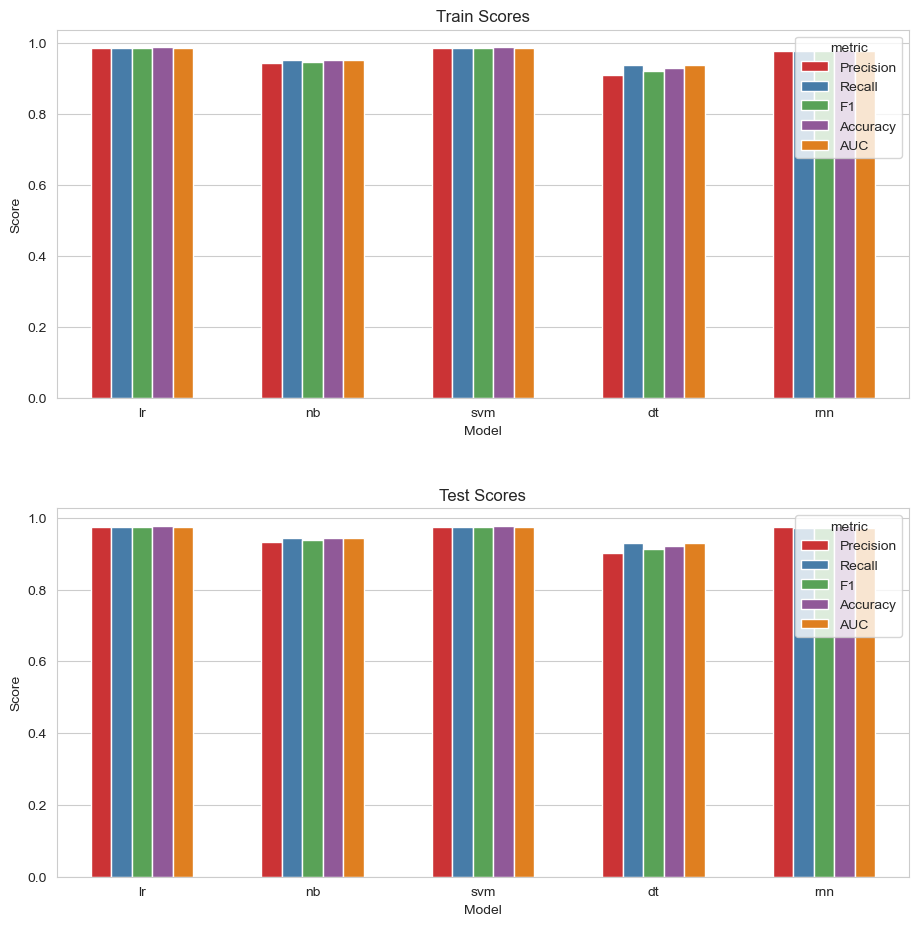

In [ ]:
# Create subplots:
fig, axs = plt.subplots(nrows=2, figsize=(11, 11))

# Adjust subplots:
plt.subplots_adjust(hspace=0.3)
sns.set_palette('Set1')
width = 0.6

# Create bar plot of training scores:
sns.barplot(x='index', y='score', hue='metric', data=train_scores_df, ax=axs[0], width=width)
axs[0].set_title('Train Scores')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Score')

# Create bar plot of test scores:
sns.barplot(x='index', y='score', hue='metric', data=test_scores_df, ax=axs[1], width=width)
axs[1].set_title('Test Scores')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Score')

# Show the plot:
plt.show()

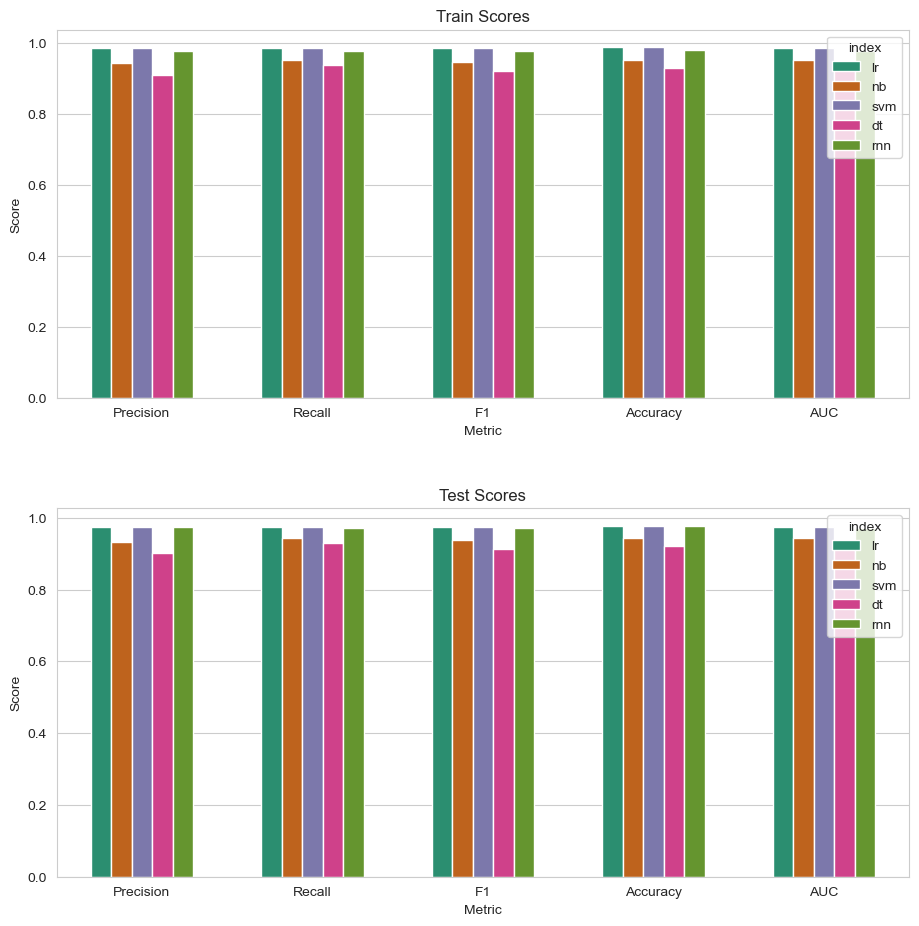

In [ ]:
# Create subplots:
fig, axs = plt.subplots(nrows=2, figsize=(11, 11))

# Adjust subplots:
plt.subplots_adjust(hspace=0.3)
sns.set_palette('Dark2')
width = 0.6

# Create bar plot of training scores:
sns.barplot(x='metric', y='score', hue='index', data=train_scores_df, ax=axs[0], width=width)
axs[0].set_title('Train Scores')
axs[0].set_xlabel('Metric')
axs[0].set_ylabel('Score')

# Create bar plot of test scores:
sns.barplot(x='metric', y='score', hue='index', data=test_scores_df, ax=axs[1], width=width)
axs[1].set_title('Test Scores')
axs[1].set_xlabel('Metric')
axs[1].set_ylabel('Score')

# Show the plot:
plt.show()

As a final comment, the RNN model appears to outperform all other algorithms. Notably, the F1-score differential between the train and test sets is a mere 0.004, indicating that the model could potentially generalize better than the other models tested. However, due to the difference in feature engineering (word embeddings instead of TF-IDF) and the longer fitting time on test data, we won't be using RNN as our best model.

#### Save best model:

In [ ]:
if not use_colab_gdrive:
    url = "tuned_models.joblib"
    models_dict = load(url)
    best_model_name = 'lr'
    best_model = models_dict[best_model_name]

    # Add tfidf step before saving the best model:
    tfidf_step = ('tfidf', load('tfidf.joblib'))
    best_model.steps.insert(0, tfidf_step)

    url = "best_model.joblib"
    dump(best_model, url)

## Part 2 – Sentiment classification:

Your task is to apply your trained sentiment classification model from Part 1 to datasets related to russia’s war in Ukraine. You are also encouraged to use pre-trained sentiment classification models implemented as Python libraries and on-Cloud (AWS, Google Cloud, Microsoft Azure Cloud, IBM Cloud) to compare results of your model from Part 1 with pre-trained models. You can use datasets and publications suggested here and find your own datasets:
- Opinion of influencers – tweets of Elon Musk and responses to his tweets (posted on Quercus)
- Reddit sentiment analysis https://medium.com/@suhdong21/sentiment-analysis-of-reddit-comments-on-russia-ukraine-war-with-python-a3632994942b
- Tweets analysis (sentiment, topic, personnel & resource losses) https://omkargawade.medium.com/russia-ukraine-war-tweets-nlp-analysis-bd10b352316c
- Conflict detection (pdf file "NLP Conflict Detection in the Ukraine Crisis" posted on Quercus), data sources: Reddit, social news aggregation, etc.
- Kaggle datasets collected from Reddit https://www.kaggle.com/datasets/gpreda/russian-invasion-of-ukraine and https://www.kaggle.com/datasets/diyacharya/ukraine-russia-war-reddit-data
- War in Ukraine in the Perception of the Russian Population (opinion polls, Levada Center) https://www.discuss-data.net/dataset/947f9970-7a50-493c-bc78-057f0f5eedf7/files/
- Ukrainian new source Hromadske (easily translated to English) https://hromadske.ua/tags/rosijsko-ukrayinska-vijna
- News aggregators (API or web-scraping), e.g. https://www.pressreader.com/search?query=russia%20ukraine&orderBy=Relevance&searchFor=Articles
- Google Trends https://trends.google.com, Kaggle, and similar data/news aggregation portals

Feel free to experiment with Python libraries and APIs to download news articles, e.g., https://newsapi.org/docs/client-libraries/python

Summarize results of your sentiment classifications for your datasets. For each dataset, make conclusions about your results. Explain those.

#### Import the basic libraries:

In [ ]:
if use_colab_gdrive:
    # Important note: Version 1.0.2 has incompatibility with newer versions of scikit-learn.
    # Traning and testing was done with version 1.0.2:
    !pip install scikit-learn==1.0.2

In [ ]:
import os
import glob
import requests
import sys
print(sys.version)

3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


In [ ]:
from joblib import dump, load
from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("bright")
%matplotlib inline

### 2.1. Web Scraping and Data Cleaning:

The code below, taken from https://gist.github.com/m-sean/a0c88af0e96b1740594903fdbdc9a680, allows for a set of up to 1000 comments to be retrieved from a specified request via PushShift. The comments are selected from a specific date, and iteration is performed with a fixed increment backwards in time until the desired number of scrapes have been performed. The original code has been modified to return a DataFrame for each subreddit listed below before the functional call. The individual DataFrames are later cleaned using the same algorithm as Part 1 of the project, and then written into .csv format. The name of the file contains the date that the scrape was performed and the total number of days considered (assumptions of inc = 1).

In [ ]:
try:
    from pmaw import PushshiftAPI
except:
    !pip install pmaw
    from pmaw import PushshiftAPI
import json
import requests
import re
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
try:
    import contractions
except:
    !pip install contractions
    import contractions

In [ ]:
import datetime as dt
before = int(dt.datetime(2023,2,1,0,0).timestamp())
after = int(dt.datetime(2023,12,1,0,0).timestamp())
api = PushshiftAPI()

In [ ]:
from tqdm import tqdm
from nltk import defaultdict
from time import sleep

In [ ]:
# [1] https://gist.github.com/m-sean/a0c88af0e96b1740594903fdbdc9a680
# Retrieved from [1]:

def build_dataset_ps(subreddit="UkrainianConflict"):
    """
    Scrape a specified subreddit for comments using the Pushshift API (writes JSON objects to disk).
    """

    SUB = subreddit     # subreddit to scrape
    START = 0           # lower bound for scrape (0 = today, 1 = yesterday, etc.)
    INC = 1             # increment for scrape (1 = 1 day per scrape)
    STOP = 500          # upper bound for scrape (14 = 2 weeks of data total)
    NUM = 180           # total number of comments per scrape

    SINK = "reddit-data.json"

    # Define an iterator using Pushift API for the scrape:
    def yield_request(sub, start, stop, inc, num):
        while start <= stop:
            try:
                r = requests.get(f'https://api.pushshift.io/reddit/search/comment/?subreddit={sub}&size={num}&before={start}d&after={start+inc}d')
                yield r.json()
                start += inc
            except json.decoder.JSONDecodeError:
                sleep(10)

    # Initialization:
    #data = []
    comments = []
    com_years = []
    com_months = []
    com_days = []
    iter = 1
    todays_date = dt.datetime.today()

    # Collect comments:
    for scrape in yield_request(SUB, START, STOP, INC, NUM):
        iter += 1

        # Get the date to be stored
        incremented_date = todays_date + dt.timedelta(days=-(iter-1))
        print("Scraped comments for " + incremented_date.strftime("%d %B, %Y"))

        # Update comments list:
        for data_i in scrape['data']:
            comments.append(data_i['body'])
            com_years.append(incremented_date.year)
            com_months.append(incremented_date.month)
            com_days.append(incremented_date.day)

    print(f"{len(comments)} comments collected")

    df = pd.DataFrame(list(zip(com_days, com_months, com_years, comments)), columns=["Day","Month","Year","Comments"])
    return df

In [ ]:
# Same as the one in Part 1:
def clean_data(text):
    """
    Rremoves various types of unwanted information, including hashtags, HTML tags, URLs, etc.
    """

    # Remove hashtags:
    text = re.sub("#[\w]*","", text)

    # Remove twitter Return handles:
    text = re.sub("RT @[\w]*:","", text)

    # Remove user tags:
    text = re.sub("@[\w]*","", text)

    # Remove HTML tags:
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove links:
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)

    # Remove escape characters:
    text = re.sub(r"\r+|\n+|\t+", " ", text)

    # Lowercase the letters:
    text = text.lower()

    # Fix contractions:
    text = contractions.fix(text)

    # Remove punctuations:
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)

    # Filter non-letters:
    text = re.sub("[^a-zA-Z]", " ", text)

    # Tokenize to words:
    token = nltk.word_tokenize(text)

    # Define stopwords:
    neg_words = ["aren't", "aren", "ain", "can't", "cannot", "couldn't", "couldn",
                 "didn't", "didn", "doesn", "doesn't", "don", "don't", "hadn't", "hadn",
                 "hasn't", "hasn", "haven't", "haven", "isn't", "isn", "mightn't", "mightn",
                 "mustn't", "mustn", "needn't", "needn", "no", "nor", "not", "shan't", "shan",
                 "shouldn't", "shouldn", "wasn't", "wasn", "weren't", "weren", "won't", "won", "wouldn't", "wouldn"]
    sw = [w for w in stopwords.words('english') if w not in neg_words] + ['would']

    # Lemmatize:
    wn = nltk.stem.WordNetLemmatizer()
    text = [wn.lemmatize(w) for w in token if w not in sw]

    # Rejoin the words:
    return " ".join(text)

First, we'll check if a clean data file is available. If not, we'll use `build_dataset_ps` to retrieve Reddit data and apply the `clean_data` function to ensure it's ready for analysis. Both functions provide step-by-step instructions for data cleaning. Once the data is cleaned, we'll save the clean dataframe to avoid repeating the cleaning process in future runs.

After loading, we'll check for any null values in the 'clean' column. Since we expect only a few missing values, we can simply drop those rows.

In [ ]:
if not use_colab_gdrive:
    csv_files = glob.glob("*.csv")
    pattern = r"clean_aux_data_reddit_\d+_\w+_\d{4}_no\d+\.csv"

    # Check to see if any clean data file exists:
    for i, file in enumerate(csv_files):
        if re.match(pattern, file):
            url = file
            print("'{}' already exists.".format(url))
            print(f"Index of first .csv match in directory: {i}")
            break
    else:
        subreddits = ["UkrainianConflict", "Ukraine", "UkraineWarVideoReport"]
        dfs = []
        for subreddit in subreddits:
            print("\n\033[1mBuilding dataset for subreddit: [" + subreddit + "]\033[0m")
            dfs.append(build_dataset_ps(subreddit))
        for df in dfs:
            df["Clean"] = df["Comments"].apply(clean_data)

            # Make sure moderated comments are removed:
            T = (df["Comments"]!="[removed]") & (df["Comments"]!="[deleted]")
            df = df[T]

        # Concatenate, insert proper dates then save clean data file:
        filename = "aux_data_reddit_" + dt.datetime.today().strftime("%d_%B_%Y") + "_no" + str(180)
        df_tot = pd.concat([df for df in dfs])
        df_tot.drop("Comments", inplace=True, axis=1)
        df_tot["Dates"] = pd.to_datetime(df_tot[['Day','Month','Year']])

        # Replace empty strings with nan values:
        df_tot['Clean'] = df_tot['Clean'].replace("", np.nan)
        idx = df_tot[df_tot['Clean'].isna()].index
        df_tot = df_tot.drop(idx)
        df_tot.reset_index(inplace=True, drop=True)

        url = "clean_" + filename + ".csv"
        df_tot.to_csv(url, index=False)

    # Create a pandas dataframe:
    df = pd.read_csv(url)
else:
    # Set the URL for the 'clean_aux_data_reddit_01_April_2023_no180' file:
    url = "https://drive.google.com/file/d/1gR4K5mhA2t3zl3AtViarDX93EbthZ7wf/view?usp=share_link"
    url = "https://drive.google.com/uc?id=" + url.split('/')[-2]

    # Create a pandas dataframe:
    df = pd.read_csv(url)

'clean_aux_data_reddit_01_April_2023_no180.csv' already exists.
Index of first .csv match in directory: 1


In [ ]:
df.head()

,Day,Month,Year,Clean,Dates
0,31,12,2022,condition weapon abysmal looking saw seriously...,2022-12-31
1,31,12,2022,please take time read policy zero tolerance po...,2022-12-31
2,31,12,2022,maybe time take iran,2022-12-31
3,31,12,2022,seriously ok nato invading belarus,2022-12-31
4,31,12,2022,click aa top right click show reader using app...,2022-12-31


In [ ]:
print(f"Dataframe shape: {df.shape}")

# Finall check for null values:
df['Clean'] = df['Clean'].replace('', np.nan)
idx = df[df['Clean'].isna()].index
print("Null values in 'Clean' column:", len(idx))

Dataframe shape: (465450, 5)
Null values in 'Clean' column: 0


### 2.2. Apply Best Model on Unlabeled Set:

In [ ]:
if not use_colab_gdrive:
    url = "best_model.joblib"
    best_model = load(url)
else:
    url = "https://drive.google.com/file/d/1n1NTtznikNUorlfKmhn_NB0owedlmTBr/view?usp=share_link"

    # Extract file ID from URL:
    file_id = url.split('/')[-2]

    # Set destination file path and name:
    destination = "best_model.joblib"

    # Download file from Google Drive:
    response = requests.get(f"https://drive.google.com/uc?id={file_id}")
    content = response.content

    # Save file locally:
    with open(destination, 'wb') as f:
        f.write(content)

    # Load file:
    best_model = load(destination)

# Print steps:
table = tabulate(best_model.steps, headers=['Step', 'Transformer'], tablefmt="fancy_grid")
print(table)

╒════════╤═══════════════════════════════════════════════════════════════╕
│ Step   │ Transformer                                                   │
╞════════╪═══════════════════════════════════════════════════════════════╡
│ tfidf  │ TfidfVectorizer(max_df=0.9)                                   │
├────────┼───────────────────────────────────────────────────────────────┤
│ lr     │ LogisticRegression(C=10, fit_intercept=False, max_iter=10000) │
╘════════╧═══════════════════════════════════════════════════════════════╛


In [ ]:
# Note: This operation may be memory intensive:
X_test_array = df['Clean'].values
y_pred_model = best_model.predict(X_test_array)

In [ ]:
# Calculate the counts of positive and negative labels:
positive_count = np.sum(y_pred_model == 1)
negative_count = np.sum(y_pred_model == 0)

# Create a table with the counts of positive and negative labels:
table = [["Positive", positive_count], ["Negative", negative_count]]

# Print the table:
print(tabulate(table, headers=["Sentiment", "Count"], tablefmt="fancy_grid"))

╒═════════════╤═════════╕
│ Sentiment   │   Count │
╞═════════════╪═════════╡
│ Positive    │  103312 │
├─────────────┼─────────┤
│ Negative    │  362138 │
╘═════════════╧═════════╛


In [ ]:
sentiment_df_model = pd.concat([df, pd.DataFrame({'Sentiment': y_pred_model})], axis=1)
sentiment_df_model.head()

,Day,Month,Year,Clean,Dates,Sentiment
0,31,12,2022,condition weapon abysmal looking saw seriously...,2022-12-31,0
1,31,12,2022,please take time read policy zero tolerance po...,2022-12-31,0
2,31,12,2022,maybe time take iran,2022-12-31,0
3,31,12,2022,seriously ok nato invading belarus,2022-12-31,0
4,31,12,2022,click aa top right click show reader using app...,2022-12-31,0


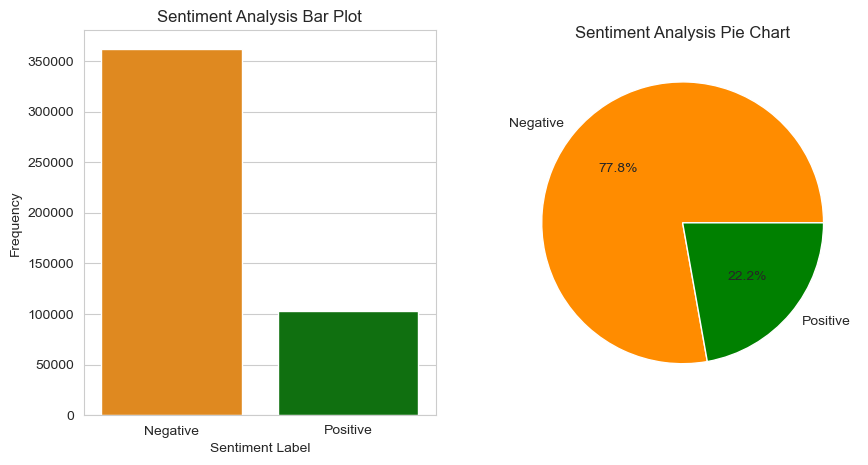

In [ ]:
# Create a figure with two subplots:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create a bar plot of sentiment labels:
sentiment_counts = np.bincount(y_pred_model)
sns.barplot(x=['Negative', 'Positive'], y=sentiment_counts, ax=ax1, palette=['#FF8C00', 'green'])
ax1.set_xlabel('Sentiment Label')
ax1.set_ylabel('Frequency')
ax1.set_title('Sentiment Analysis Bar Plot')

# Create a pie chart of sentiment labels:
sentiment_labels = ['Negative', 'Positive']
colors = ['#FF8C00', 'green']
ax2.pie(sentiment_counts, labels=sentiment_labels, autopct='%1.1f%%', colors=colors)
ax2.set_title('Sentiment Analysis Pie Chart')

# Show the plots:
plt.show()

### 2.3. Apply Pre-trained Models:

VADER and TextBlob are pretrained classification models that return a polarity value ranging between 0 and 1. Since our best model can only predict negative and positive values, it's not entirely fair to compare its performance with these pretrained models as they operate differently and have different levels of granularity in their predictions. In our case, our best model is apparantly classifying any nuetral comment as negative, and consequently, we classify any comment with polarity less than or equal to zero as negative interpreting VADER or TextBlob predictions.

In [ ]:
# NLTK Vader
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

# VADER Sentiment:
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except:
    !pip install vaderSentiment
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# TextBlob:
try:
    from textblob import TextBlob
except:
    !pip install textblob
    from textblob import TextBlob
from sklearn.metrics import classification_report

#### VADER Sentiment:

In [ ]:
# Running VADER on caloab can take around two minuts.
# Create a SentimentIntensityAnalyzer object:
sid = SentimentIntensityAnalyzer()

# Define a lambda function for sentiment classification:
classify_sentiment = np.vectorize(lambda comment: sid.polarity_scores(comment)['compound'])

# Apply the vectorized function to the numpy array:
y_pred_vader = classify_sentiment(X_test_array)

In [ ]:
sentiment_df_vader = pd.concat([df, pd.DataFrame({'Sentiment': y_pred_vader})], axis=1)
sentiment_df_vader.head()

,Day,Month,Year,Clean,Dates,Sentiment
0,31,12,2022,condition weapon abysmal looking saw seriously...,2022-12-31,-0.8074
1,31,12,2022,please take time read policy zero tolerance po...,2022-12-31,-0.1830
2,31,12,2022,maybe time take iran,2022-12-31,0.0000
3,31,12,2022,seriously ok nato invading belarus,2022-12-31,0.1280
4,31,12,2022,click aa top right click show reader using app...,2022-12-31,-0.0418


#### TextBlob:

In [ ]:
# Running TextBlob on caloab can take around two minuts.
# Define a lambda function for sentiment classification:
classify_sentiment = np.vectorize(lambda comment: TextBlob(comment).sentiment.polarity)

# Apply the vectorized function to the numpy array:
y_pred_textblob = classify_sentiment(X_test_array)

In [ ]:
sentiment_df_textblob = pd.concat([df, pd.DataFrame({'Sentiment': y_pred_textblob})], axis=1)
sentiment_df_textblob.head()

,Day,Month,Year,Clean,Dates,Sentiment
0,31,12,2022,condition weapon abysmal looking saw seriously...,2022-12-31,-0.253409
1,31,12,2022,please take time read policy zero tolerance po...,2022-12-31,0.050000
2,31,12,2022,maybe time take iran,2022-12-31,0.000000
3,31,12,2022,seriously ok nato invading belarus,2022-12-31,0.500000
4,31,12,2022,click aa top right click show reader using app...,2022-12-31,0.178571


#### Classify sentiment:

In order to evaluate the sentiment scores given by VADER and TextBlob, it is necessary to set a threshold that separates positive and negative comments from neutral ones. By varying this threshold, we observed that the number of negative comments can be significantly affected, while the number of positive comments remains relatively stable. These results further validate our developed model, which predicted that most comments would be negative in sentiment. Therefore, when comparing the performance of TextBlob and VADER with our model, we may consider treating neutral comments as negative.

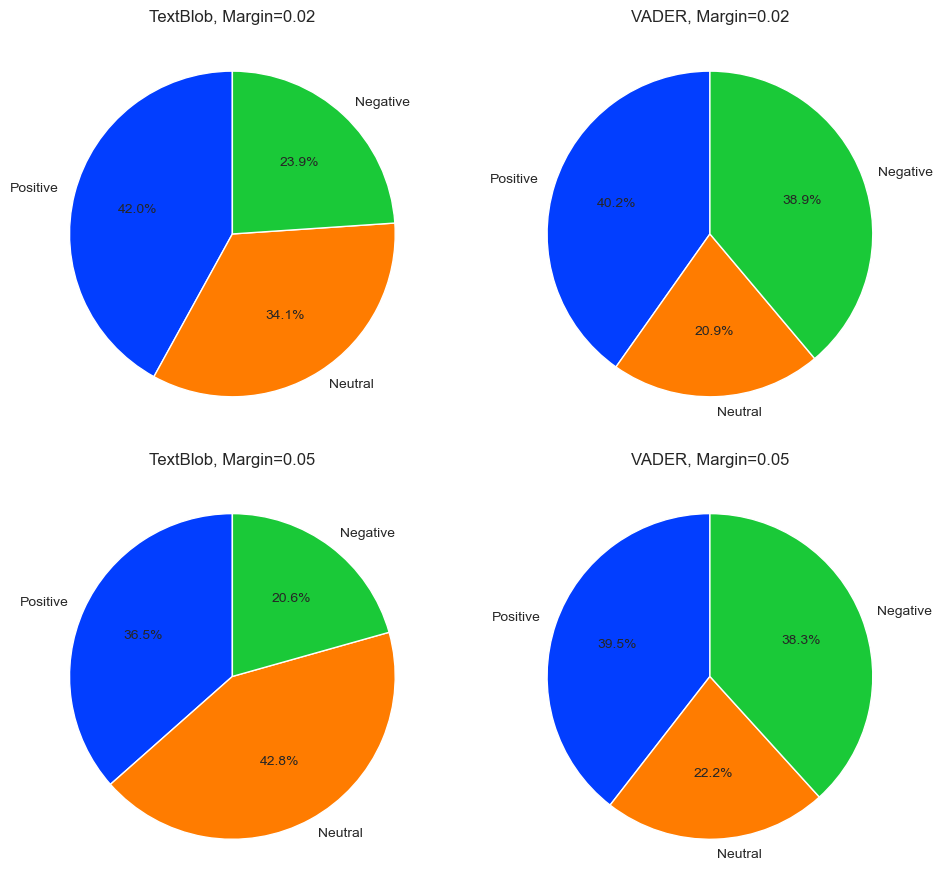

In [ ]:
# Define an array of margins:
margins = [0.02, 0.05]

# Define labels for the three arrays:
pie_labels = ['Positive', 'Neutral', 'Negative']

# Create a figure with subplots in two columns:
fig, axs = plt.subplots(len(margins), 2, figsize=(10,9))

# Loop over the margins and plot the pie charts on each subplot:
for i, margin in enumerate(margins):

    # Define data for the TextBlob array:
    data_textblob = [len(y_pred_textblob[y_pred_textblob>margin]),
                     len(y_pred_textblob[(y_pred_textblob >= -margin) & (y_pred_textblob <= margin)]),
                     len(y_pred_textblob[y_pred_textblob<-margin])]

    # Define data for the Vader array:
    data_vader = [len(y_pred_vader[y_pred_vader>margin]),
                 len(y_pred_vader[(y_pred_vader >= -margin) & (y_pred_vader <= margin)]),
                 len(y_pred_vader[y_pred_vader<-margin])]

    # Plot the TextBlob pie chart on the left subplot:
    axs[i, 0].pie(data_textblob, labels=pie_labels, autopct='%1.1f%%', startangle=90)
    axs[i, 0].set_title(f'TextBlob, Margin={margin}')

    # Plot the Vader pie chart on the right subplot:
    axs[i, 1].pie(data_vader, labels=pie_labels, autopct='%1.1f%%', startangle=90)
    axs[i, 1].set_title(f'VADER, Margin={margin}')

# Adjust the spacing between subplots:
plt.tight_layout()

# Display the plot:
plt.show()

At last, we choose 0.02 as the final margin and classify the sentiments before saving the results.

In [ ]:
# Classify sentiments:
margin = 0.02
sentiment_df_vader['Sentiment'] = sentiment_df_vader['Sentiment'].apply(lambda score: 1 if score > margin
                                                                        else (-1 if score < -margin else 0))
sentiment_df_textblob['Sentiment'] = sentiment_df_textblob['Sentiment'].apply(lambda score: 1 if score > margin
                                                                              else (-1 if score < -margin else 0))

#### VADER Sentiment:

In [ ]:
sentiment_df_vader.head()

,Day,Month,Year,Clean,Dates,Sentiment
0,31,12,2022,condition weapon abysmal looking saw seriously...,2022-12-31,-1
1,31,12,2022,please take time read policy zero tolerance po...,2022-12-31,-1
2,31,12,2022,maybe time take iran,2022-12-31,0
3,31,12,2022,seriously ok nato invading belarus,2022-12-31,1
4,31,12,2022,click aa top right click show reader using app...,2022-12-31,-1


#### TextBlob:

In [ ]:
sentiment_df_vader.head()

,Day,Month,Year,Clean,Dates,Sentiment
0,31,12,2022,condition weapon abysmal looking saw seriously...,2022-12-31,-1
1,31,12,2022,please take time read policy zero tolerance po...,2022-12-31,-1
2,31,12,2022,maybe time take iran,2022-12-31,0
3,31,12,2022,seriously ok nato invading belarus,2022-12-31,1
4,31,12,2022,click aa top right click show reader using app...,2022-12-31,-1


#### Save predictions:

In [ ]:
if not use_colab_gdrive:
    models = ['best_model', 'vader', 'textblob']
    dfs = [sentiment_df_model, sentiment_df_vader, sentiment_df_textblob]
    for i, model in enumerate(models):
        url = model + "_predicted_sentiments" + ".csv"
        dfs[i].to_csv(url, index=False)

### 2.3. Model Comparison:

In [ ]:
# Same as the one in Part 1:
def print_classification_report(y_true, y_pred):
    """
    Formats classification report.
    """
    # Classification report dictionary:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame.from_dict(report_dict)

    # Insert empty row above 'accuracy':
    report_df.insert(loc=2, column='', value=[None]*report_df.shape[0])
    report_df = report_df.transpose()

    # Convert support values to strings:
    report_df.loc['accuracy', 'support'] = report_df.loc['0', 'support'] + report_df.loc['1', 'support']
    report_df.loc['', 'support'] = 0
    report_df['support'] = report_df['support'].astype('int').astype('str')
    report_df.loc['', 'support'] = ''

    # Print the results as a table:
    print(report_df.to_markdown(tablefmt='fancy_outline', floatfmt='.3f'))
    return report_dict

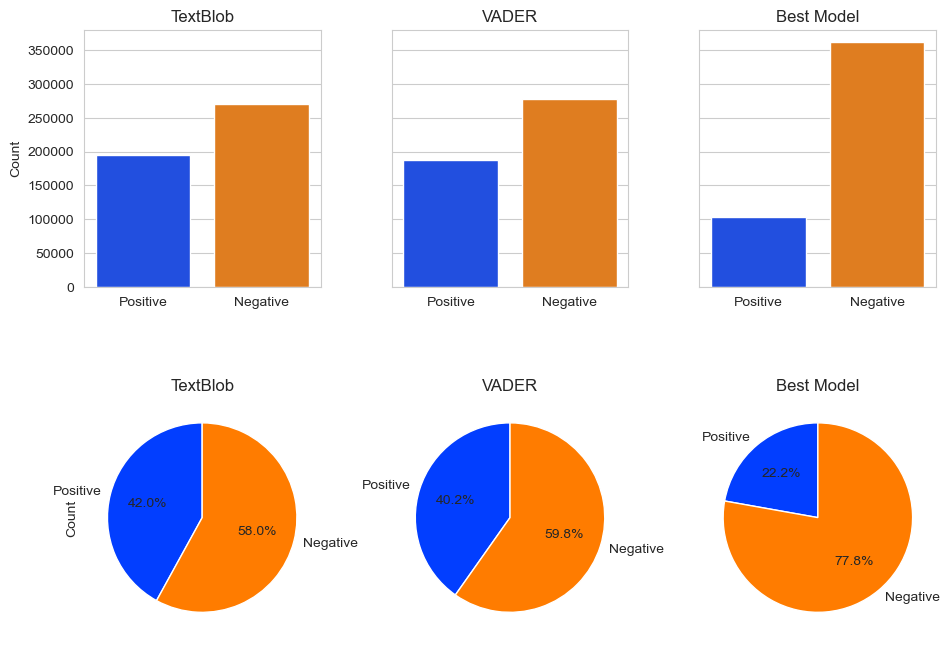

In [ ]:
# Define labels and data for the three arrays:
margin = 0.02
labels = ['Positive', 'Negative']
data_textblob = [len(y_pred_textblob[y_pred_textblob>margin]), len(y_pred_textblob[y_pred_textblob<=margin])]
data_vader = [len(y_pred_vader[y_pred_vader>margin]), len(y_pred_vader[y_pred_vader<=margin])]
data_model = [len(y_pred_model[y_pred_model==1]), len(y_pred_model[y_pred_model==0])]

# Define subplots for the three arrays and share y-axis:
fig, axs = plt.subplots(2, 3, figsize=(11, 8), sharey='row', gridspec_kw={'height_ratios': [1, 1]})
(ax1, ax2, ax3), (ax4, ax5, ax6) = axs

# Set title and data for first row:
ax1.set_title('TextBlob')
sns.barplot(x=labels, y=data_textblob, ax=ax1)
ax2.set_title('VADER')
sns.barplot(x=labels, y=data_vader, ax=ax2)
ax3.set_title('Best Model')
sns.barplot(x=labels, y=data_model, ax=ax3)

# Add y-axis labels:
ax1.set_ylabel('Count')
ax4.set_ylabel('Count')

# Define labels and data for the pie charts:
pie_labels = ['Positive', 'Negative']
pie_data_textblob = data_textblob
pie_data_vader = data_vader
pie_data_model = data_model

# Set title and data for second row:
ax4.set_title('TextBlob')
ax4.pie(pie_data_textblob, labels=pie_labels, autopct='%1.1f%%', startangle=90)
ax5.set_title('VADER')
ax5.pie(pie_data_vader, labels=pie_labels, autopct='%1.1f%%', startangle=90)
ax6.set_title('Best Model')
ax6.pie(pie_data_model, labels=pie_labels, autopct='%1.1f%%', startangle=90)

# Adjust the spacing between the subplots:
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Show the plot:
plt.show()

In [ ]:
# Classification report for VADER:
margin = 0.02
y_true = np.where(y_pred_vader<=margin, 0, 1)
y_pred = y_pred_model
print(f"Best model classification report when compared against VADER:")
report_dict = print_classification_report(y_true, y_pred)
print('')

# Classification report for TextBlob:
y_true = np.where(y_pred_textblob<=margin, 0, 1)
y_pred = y_pred_model
print(f"Best model classification report when compared against TextBlob:")
report_dict = print_classification_report(y_true, y_pred)

Best model classification report when compared against VADER:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │       0.678 │    0.883 │      0.767 │ 278287    │
│ 1            │       0.684 │    0.377 │      0.486 │ 187163    │
│              │             │          │            │           │
│ accuracy     │       0.679 │    0.679 │      0.679 │ 465450    │
│ macro avg    │       0.681 │    0.630 │      0.627 │ 465450    │
│ weighted avg │       0.680 │    0.679 │      0.654 │ 465450    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛

Best model classification report when compared against TextBlob:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│

If we exclude the neutral comments from our analysis, the accuracy of our model may vary. As the tables below illustrate, when we remove the neutral comments, both the f1-score and accuracy of our model decrease. Interestingly, we observe that the decrease in performance is much smaller when we exclude the neutral values predicted by VADER. This finding suggests that our model agrees better with VADER predictions.

In [ ]:
margin = 0.02

# Remove neutral comments according to VADER:
idx = (y_pred_vader>margin) | (y_pred_vader<-margin)
y_pred_model_vader = y_pred_model[idx]
y_pred_vader_reduced = y_pred_vader[idx]
y_pred_vader_reduced = np.where(y_pred_vader_reduced<0, 0, 1)

# Remove neutral comments according to TextBlob:
idx = (y_pred_textblob>margin) | (y_pred_textblob<-margin)
y_pred_model_textblob = y_pred_model[idx]
y_pred_textblob_reduced = y_pred_textblob[idx]
y_pred_textblob_reduced = np.where(y_pred_textblob_reduced<0, 0, 1)

In [ ]:
# Classification report for VADER:
y_true = y_pred_vader_reduced
y_pred = y_pred_model_vader
print(f"Best model classification report when compared against VADER:")
report_dict = print_classification_report(y_true, y_pred)
print('')

# Classification report for TextBlob:
y_true = y_pred_textblob_reduced
y_pred = y_pred_model_textblob
print(f"Best model classification report when compared against TextBlob:")
report_dict = print_classification_report(y_true, y_pred)

Best model classification report when compared against VADER:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │       0.597 │    0.954 │      0.735 │ 180944    │
│ 1            │       0.895 │    0.377 │      0.531 │ 187163    │
│              │             │          │            │           │
│ accuracy     │       0.661 │    0.661 │      0.661 │ 368107    │
│ macro avg    │       0.746 │    0.666 │      0.633 │ 368107    │
│ weighted avg │       0.749 │    0.661 │      0.631 │ 368107    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛

Best model classification report when compared against TextBlob:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │ support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│

The results indicate that the model achieves an accuracy of 66% and 55% when compared to VADER and TextBlob, respectively. While these results suggest that the model has some predictive power, there are many ways in which its performance could be improved. For instance, one could use a larger and more diverse training set to improve the model's vocabulary and overall predictive ability. Alternatively, one could add complexity to the model or explore the use of multiclass classification to capture more nuanced sentiment in the text.

It's worth noting that the best model predictions are generally negative in sentiment, which may reflect the prevalence of negative sentiment in the dataset. Both TextBlob and VADER also identify a significant amount of negative sentiment in the Reddit data in relation to the Russia-Ukraine war.

## Part 3 – Factor and topics identification via Machine Learning:

Based on your sentiment analysis results (especially looking at posts/tweets with negative and positive sentiment, as posts/tweets with neutral sentiment are less informative), you will need to identify factors/reasons/topics that drive sentiment. Those are factors (reasons, topics) that explain sentiment and can be used for decision making and recommendations in Part 4. You can use any Natural Language Processing models for this part of the project (use existing models or develop your own).

In [ ]:
use_colab_gdrive = True

#### Import the basic libraries:

In [ ]:
if use_colab_gdrive:
    # Important note: Version 1.0.2 has incompatibility with newer versions of scikit-learn.
    # Traning and testing was done with version 1.0.2:
    !pip install scikit-learn==1.0.2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("bright")
%matplotlib inline
import requests

In this analysis, the complete dataset of sanitized Reddit comments is examined. Initially, the necessary packages are imported, assuming that other packages such as `pandas` and `numpy` are already accessible. Sources for conducting LDA using `pyLDAvis` are referenced in the comments. Next, the analyst sets up the vectorizer for `feature_extraction` and trains the TF-IDF model and fits the LDA model using the cleansed comments. Lastly, the aforementioned models, along with the original vectorizer, are passed to pyLDAvis to activate the notebook analyzer.

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

try:
    import pyLDAvis.sklearn
except:
    !pip install pyLDAvis
    import pyLDAvis.sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#### Load predictions:

In [ ]:
if not use_colab_gdrive:
    models = ['best_model', 'vader', 'textblob']
    dfs = [None] * len(models)

    for i, model in enumerate(models):
        url = model + "_predicted_sentiments" + ".csv"
        dfs[i] = pd.read_csv(url)

    sentiment_df_model, sentiment_df_vader, sentiment_df_textblob = dfs
else:
    # Set the URL for the 'best_model_predicted_sentiments.csv' file:
    url = "https://drive.google.com/file/d/11PlkDxTs_gTn9gdvmrujf-944bdYF0X7/view?usp=share_link"
    url = "https://drive.google.com/uc?id=" + url.split('/')[-2]

    # Create a pandas dataframe:
    sentiment_df_model = pd.read_csv(url)

    # Set the URL for the 'vader_predicted_sentiments.csv' file:
    url = "https://drive.google.com/file/d/1-mLXQqe7zvHZe-ockOjOstwAK4267VA0/view?usp=share_link"
    url = "https://drive.google.com/uc?id=" + url.split('/')[-2]

    # Create a pandas dataframe:
    sentiment_df_vader = pd.read_csv(url)

    # Set the URL for the 'textblob_predicted_sentiments.csv' file:
    url = "https://drive.google.com/file/d/1UryYvDaRekAngFERuxquRAl5HOOLnlWk/view?usp=share_link"
    url = "https://drive.google.com/uc?id=" + url.split('/')[-2]

    # Create a pandas dataframe:
    sentiment_df_textblob = pd.read_csv(url)

In [ ]:
sentiment_df_vader.head()

,Day,Month,Year,Clean,Dates,Sentiment
0,31,12,2022,condition weapon abysmal looking saw seriously...,2022-12-31,-1
1,31,12,2022,please take time read policy zero tolerance po...,2022-12-31,-1
2,31,12,2022,maybe time take iran,2022-12-31,0
3,31,12,2022,seriously ok nato invading belarus,2022-12-31,1
4,31,12,2022,click aa top right click show reader using app...,2022-12-31,-1


### 3.1. Analysis of 2022 Reddit Data:

#### Negative sentiments:

In [ ]:
# # [1] https://towardsdatascience.com/topic-model-visualization-using-pyldavis-fecd7c18fbf6
# # [2] https://medium.com/mlearning-ai/nlp-day-7-your-story-your-topic-your-tf-idf-7c06c9c1196a
# # [3] https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# # [4] https://griddb.net/en/blog/topic-modeling-with-lda-using-python-and-griddb/

# # Extract data:
# idx = (sentiment_df_vader['Sentiment']==-1)
# df_tot = sentiment_df_vader[idx]

# # Enable pyLDAvis:
# pyLDAvis.enable_notebook()

# # Apply TF-IDF:
# tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
#                                 stop_words = 'english',
#                                 lowercase = True,
#                                 token_pattern = r'\b[a-zA-Z]{3,}\b',
#                                 max_df = 0.5,
#                                 min_df = 10)
# tfidf = TfidfVectorizer(**tf_vectorizer.get_params())
# lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)

# # Fit and transform on clean data:
# X_tfidf = tfidf.fit_transform(df_tot["Clean"])
# lda_tfidf.fit(X_tfidf)

# # open the pyLDAvis notebook:
# pyLDAvis.sklearn.prepare(lda_tfidf, X_tfidf, tfidf)

D:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.054138 -0.138052       1        1  11.251604
4      0.051361 -0.073426       2        1  10.190544
19     0.039888 -0.129736       3        1   9.707501
0      0.050718  0.010349       4        1   8.241374
1      0.047279 -0.017640       5        1   7.127434
2     -0.567226 -0.036104       6        1   6.195127
5      0.056049 -0.091360       7        1   5.034855
14     0.042011 -0.097912       8        1   4.460221
17     0.044046 -0.105754       9        1   4.195632
3      0.025988 -0.031295      10        1   3.788254
15     0.027771  0.082008      11        1   3.645591
16     0.020447  0.096432      12        1   3.207855
6      0.022462  0.025146      13        1   3.146812
11     0.009080  0.066141      14        1   3.109435
12     0.028907  0.025817      15        1   3.041520
10     0.020017  0.091762      16        1   2.910642
8      0.016281  0.115113      17        1   2.845083
9      0.014134  0.092653      18        1   2.745172
18    -0.002086  0.096775      19        1   2.615652
13    -0.001264  0.019082      20        1   2.539694, topic_info=            Term         Freq        Total Category  logprob  loglift
9452      policy  1772.000000  1772.000000  Default  30.0000  30.0000
5204        fuck  2250.000000  2250.000000  Default  29.0000  29.0000
2369     comment  1984.000000  1984.000000  Default  28.0000  28.0000
2461     compose   919.000000   919.000000  Default  27.0000  27.0000
9175   performed   926.000000   926.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1468         bot    63.980454  1198.202053  Topic20  -5.4931   0.7431
2661     context    55.109429   964.887049  Topic20  -5.6423   0.8104
9159      people    54.432668  2490.664109  Topic20  -5.6547  -0.1502
13305  ukrainian    51.842884  1760.778186  Topic20  -5.7034   0.1478
7322        like    48.516452  2881.399035  Topic20  -5.7698  -0.4110

[1656 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
27        12  0.927180  abraham
29         1  0.041272   abrams
29         3  0.928626   abrams
29         9  0.020636   abrams
53         4  0.899216   abuser
...      ...       ...      ...
14355      7  0.022123   zombie
14355      9  0.022123   zombie
14355     17  0.685828   zombie
14359      7  0.097495     zoom
14359     10  0.877455     zoom

[9275 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 20, 1, 2, 3, 6, 15, 18, 4, 16, 17, 7, 12, 13, 11, 9, 10, 19, 14])

#### Positive sentiments:

In [ ]:
# # Extract data:
# idx = (sentiment_df_vader['Sentiment']==1)
# df_tot = sentiment_df_vader[idx]

# # Enable pyLDAvis:
# pyLDAvis.enable_notebook()

# # Apply TF-IDF:
# tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
#                                 stop_words = 'english',
#                                 lowercase = True,
#                                 token_pattern = r'\b[a-zA-Z]{3,}\b',
#                                 max_df = 0.5,
#                                 min_df = 10)
# tfidf = TfidfVectorizer(**tf_vectorizer.get_params())
# lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)

# # Fit and transform on clean data:
# X_tfidf = tfidf.fit_transform(df_tot["Clean"])
# lda_tfidf.fit(X_tfidf)

# # open the pyLDAvis notebook:
# pyLDAvis.sklearn.prepare(lda_tfidf, X_tfidf, tfidf)

D:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.113638  0.024296       1        1  11.399726
1      0.113761  0.013718       2        1  11.052284
8      0.103767  0.000901       3        1   8.138686
15     0.108346  0.011020       4        1   6.118620
16     0.099992 -0.011562       5        1   6.044680
9      0.100592  0.033432       6        1   5.887761
0     -0.487657  0.100618       7        1   5.633511
13     0.104301  0.013005       8        1   4.847407
14    -0.392563 -0.122794       9        1   4.442151
11     0.110190  0.026229      10        1   4.146452
6      0.102596  0.033989      11        1   3.932301
2      0.103980  0.012147      12        1   3.898483
18     0.099081  0.010001      13        1   3.646875
19     0.087935  0.009058      14        1   3.270846
4      0.101488  0.036645      15        1   3.223418
7     -0.434837  0.188055      16        1   3.148290
12     0.094669  0.031220      17        1   3.131949
3     -0.003561 -0.050658      18        1   2.877108
10     0.051721 -0.028698      19        1   2.663309
5     -0.177439 -0.330621      20        1   2.496146, topic_info=               Term         Freq        Total Category  logprob  loglift
9746           rule  2409.000000  2409.000000  Default  30.0000  30.0000
795   automatically  3784.000000  3784.000000  Default  29.0000  29.0000
2212        compose  3763.000000  3763.000000  Default  28.0000  28.0000
8179      performed  3756.000000  3756.000000  Default  27.0000  27.0000
2239        concern  3761.000000  3761.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
9351        removed   164.638404  2545.833036  Topic20  -4.4667   0.9520
2383        content   118.898525  1038.626399  Topic20  -4.7921   1.5230
8484           post   136.325676  3274.064386  Topic20  -4.6554   0.5117
4608           free    99.566496   680.342843  Topic20  -4.9696   1.7687
2159      community    81.533148  1018.174319  Topic20  -5.1694   1.1657

[1555 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
16         1  0.909226    abrams
16         2  0.016531    abrams
16         6  0.033063    abrams
16        11  0.049594    abrams
79         1  0.129189  accuracy
...      ...       ...       ...
12767      2  0.123848   zealand
12767      3  0.825656   zealand
12784      1  0.035733    zombie
12784     12  0.893331    zombie
12784     19  0.071466    zombie

[7625 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 2, 9, 16, 17, 10, 1, 14, 15, 12, 7, 3, 19, 20, 5, 8, 13, 4, 11, 6])

### 3.2. Monthly Analysis of Reddit Data:

The previous code structure has been replaced with a similar loop used in generating the transient boxplot chart in Part II. The updated code first groups the data by months, calculates the total number of cleaned comments per month, and then generates subsets of data based on that number. Modeling is then performed on these subsets, similar to the full dataset. To avoid running the entire code each time, the notebook is opened in a separate cell to review results for a specific month.

#### Negative sentiments:

In [ ]:
# # Extract data:
# idx = (sentiment_df_vader['Sentiment']==-1)
# df_tot = sentiment_df_vader[idx]

# # Enable pyLDAvis:
# pyLDAvis.enable_notebook()

# # Prepare the month-by-month access pattern by grouping by month.
# # Store keys and counts for the groups:
# df_tot.sort_values(by=["Dates"], ascending=True, inplace=True)
# group = df_tot.groupby(["Month"])
# dates_list = group.groups.keys()
# counts_list = group["Month"].count().values

# # Parameters for vectorizer:
# tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
#                                 stop_words = 'english',
#                                 lowercase = True,
#                                 token_pattern = r'\b[a-zA-Z]{3,}\b',
#                                 max_df = 0.5,
#                                 min_df = 10)

# # Loop over the months using the comment counts in the DataFrame.
# # Get the subset, the fit the data for LDA and store for later access:
# agg_count = 0
# iloc_col = df_tot.columns.get_loc("Clean")
# iloc_dates = df_tot.columns.get_loc("Month")
# df_subsets = []
# models_lda = []
# tfidf_lda = []
# Xs_lda = []
# i_c = 1
# for counts_i in counts_list:
#     print("Month " + str(i_c) + ", considering " + str(counts_i) + " comments...")
#     df_subset = df_tot.iloc[agg_count:agg_count+counts_i, iloc_col]

#     # Apply TF-IDF:
#     tfidf_i = TfidfVectorizer(**tf_vectorizer.get_params())
#     lda_tfidf_i = LatentDirichletAllocation(n_components=20, random_state=0)

#     # Fit and transform on clean data:
#     X_tfidf_i = tfidf_i.fit_transform(df_subset)
#     lda_tfidf_i.fit(X_tfidf_i)

#     # Append to list for later access:
#     models_lda.append(lda_tfidf_i)
#     Xs_lda.append(X_tfidf_i)
#     tfidf_lda.append(tfidf_i)

#     agg_count += counts_i
#     i_c += 1

C:\Users\Ali\AppData\Local\Temp\ipykernel_13440\2430726078.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot.sort_values(by=["Dates"], ascending=True, inplace=True)
D:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


Month 1, considering 7261 comments...
Month 2, considering 10497 comments...
Month 3, considering 16560 comments...
Month 4, considering 16119 comments...
Month 5, considering 16229 comments...
Month 6, considering 15678 comments...
Month 7, considering 16219 comments...
Month 8, considering 16622 comments...
Month 9, considering 16234 comments...
Month 10, considering 16819 comments...
Month 11, considering 16379 comments...
Month 12, considering 16327 comments...


In [ ]:
# # Let's check February 2022:
# month_of_interest = 2

# # open the pyLDAvis notebook:
# pyLDAvis.sklearn.prepare(models_lda[month_of_interest], Xs_lda[month_of_interest], tfidf_lda[month_of_interest])

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.062814  0.075054       1        1  10.908113
12    -0.077540  0.013701       2        1   8.103091
19    -0.055210 -0.006513       3        1   7.251946
11    -0.079295  0.031795       4        1   7.068861
17     0.044576  0.046287       5        1   6.414929
14    -0.042857  0.086982       6        1   5.727136
0     -0.072781  0.081644       7        1   5.625514
9     -0.018728 -0.030140       8        1   4.526201
16    -0.042596  0.013426       9        1   4.450909
18     0.067986  0.016113      10        1   4.204971
10     0.124074  0.024587      11        1   4.184962
1     -0.096206  0.037061      12        1   4.171156
3     -0.114003 -0.175501      13        1   3.760216
5      0.113188  0.050240      14        1   3.715558
15     0.122528 -0.033422      15        1   3.526034
8      0.027285 -0.130770      16        1   3.522583
7      0.093423  0.053846      17        1   3.505584
2     -0.034999  0.001752      18        1   3.242872
4      0.055641 -0.065947      19        1   3.054953
6      0.048326 -0.090196      20        1   3.034411, topic_info=            Term        Freq       Total Category  logprob  loglift
1122        fake   75.000000   75.000000  Default  30.0000  30.0000
761         dead   96.000000   96.000000  Default  29.0000  29.0000
1405        hell   92.000000   92.000000  Default  28.0000  28.0000
752         damn   54.000000   54.000000  Default  27.0000  27.0000
2381  propaganda  123.000000  123.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
3454       world    9.040356  134.652403  Topic20  -5.1351   0.7942
2430       putin    8.847491  271.555011  Topic20  -5.1567   0.0711
1759        like    8.651937  258.340007  Topic20  -5.1790   0.0987
3153        time    8.297884  167.150110  Topic20  -5.2208   0.4923
2026        need    8.189578  134.119178  Topic20  -5.2340   0.6993

[1312 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9         7  0.117460    abuse
9         8  0.587299    abuse
9        19  0.117460    abuse
11        2  0.667102  abusive
12        2  0.066979   accept
...     ...       ...      ...
3495      8  0.366787     zone
3495     12  0.091697     zone
3495     13  0.061131     zone
3495     19  0.030566     zone
3496     12  0.686815      zoo

[5113 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 13, 20, 12, 18, 15, 1, 10, 17, 19, 11, 2, 4, 6, 16, 9, 8, 3, 5, 7])

#### Positive sentiments:

In [ ]:
# # Extract data:
# idx = (sentiment_df_vader['Sentiment']==1)
# df_tot = sentiment_df_vader[idx]

# # Enable pyLDAvis:
# pyLDAvis.enable_notebook()

# # Prepare the month-by-month access pattern by grouping by month.
# # Store keys and counts for the groups:
# df_tot.sort_values(by=["Dates"], ascending=True, inplace=True)
# group = df_tot.groupby(["Month"])
# dates_list = group.groups.keys()
# counts_list = group["Month"].count().values

# # Parameters for vectorizer:
# tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
#                                 stop_words = 'english',
#                                 lowercase = True,
#                                 token_pattern = r'\b[a-zA-Z]{3,}\b',
#                                 max_df = 0.5,
#                                 min_df = 10)

# # Loop over the months using the comment counts in the DataFrame.
# # Get the subset, the fit the data for LDA and store for later access:
# agg_count = 0
# iloc_col = df_tot.columns.get_loc("Clean")
# iloc_dates = df_tot.columns.get_loc("Month")
# df_subsets = []
# models_lda = []
# tfidf_lda = []
# Xs_lda = []
# i_c = 1
# for counts_i in counts_list:
#     print("Month " + str(i_c) + ", considering " + str(counts_i) + " comments...")
#     df_subset = df_tot.iloc[agg_count:agg_count+counts_i, iloc_col]

#     # Apply TF-IDF:
#     tfidf_i = TfidfVectorizer(**tf_vectorizer.get_params())
#     lda_tfidf_i = LatentDirichletAllocation(n_components=20, random_state=0)

#     # Fit and transform on clean data:
#     X_tfidf_i = tfidf_i.fit_transform(df_subset)
#     lda_tfidf_i.fit(X_tfidf_i)

#     # Append to list for later access:
#     models_lda.append(lda_tfidf_i)
#     Xs_lda.append(X_tfidf_i)
#     tfidf_lda.append(tfidf_i)

#     agg_count += counts_i
#     i_c += 1

C:\Users\Ali\AppData\Local\Temp\ipykernel_13440\2448095061.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot.sort_values(by=["Dates"], ascending=True, inplace=True)
D:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


Month 1, considering 8335 comments...
Month 2, considering 10619 comments...
Month 3, considering 15406 comments...
Month 4, considering 15653 comments...
Month 5, considering 16885 comments...
Month 6, considering 16639 comments...
Month 7, considering 17034 comments...
Month 8, considering 17546 comments...
Month 9, considering 16902 comments...
Month 10, considering 17222 comments...
Month 11, considering 17034 comments...
Month 12, considering 17888 comments...


In [ ]:
# # Let's check February 2022:
# month_of_interest = 2

# # open the pyLDAvis notebook:
# pyLDAvis.sklearn.prepare(models_lda[month_of_interest], Xs_lda[month_of_interest], tfidf_lda[month_of_interest])

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.069193  0.028471       1        1  12.542091
11    -0.056988  0.013081       2        1   6.440882
8     -0.070136 -0.025881       3        1   6.019224
17    -0.054988  0.022515       4        1   5.668256
4     -0.065246 -0.029679       5        1   5.454811
0     -0.046638  0.014835       6        1   5.449659
19    -0.047005  0.031544       7        1   5.395712
10    -0.056385  0.012007       8        1   5.131720
3     -0.037160  0.036289       9        1   4.674935
9     -0.045140  0.022887      10        1   4.273547
16    -0.050771 -0.046093      11        1   4.221844
13    -0.032067 -0.046111      12        1   4.213734
14    -0.040422  0.004981      13        1   4.138449
2      0.212445  0.284873      14        1   4.068646
18    -0.019936 -0.039138      15        1   3.935584
1      0.440888 -0.130644      16        1   3.886965
12     0.022627  0.026567      17        1   3.672246
6     -0.035265 -0.028122      18        1   3.653808
7      0.047906 -0.066308      19        1   3.644286
15     0.003475 -0.086074      20        1   3.513601, topic_info=               Term        Freq       Total Category  logprob  loglift
280             bot  166.000000  166.000000  Default  30.0000  30.0000
2610         thanks  142.000000  142.000000  Default  29.0000  29.0000
2206           rule  129.000000  129.000000  Default  28.0000  28.0000
176   automatically   95.000000   95.000000  Default  27.0000  27.0000
1595        message  108.000000  108.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
2614          think   10.386588  172.384683  Topic20  -4.9776   0.5393
1403           know   10.176052  187.113153  Topic20  -4.9981   0.4369
2012          putin    9.894811  191.725293  Topic20  -5.0261   0.3845
623             day    9.065547   90.310211  Topic20  -5.1136   1.0498
1500            lol    9.326594  195.164095  Topic20  -5.0852   0.3076

[1245 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4         8  0.802331    absolute
5         1  0.150723  absolutely
5         2  0.090434  absolutely
5         3  0.060289  absolutely
5         4  0.060289  absolutely
...     ...       ...         ...
2915     15  0.350358    zelensky
2918      3  0.141241        zone
2918     12  0.564966        zone
2918     14  0.070621        zone
2918     19  0.141241        zone

[4395 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 12, 9, 18, 5, 1, 20, 11, 4, 10, 17, 14, 15, 3, 19, 2, 13, 7, 8, 16])

## Part 4 – Visualizations, storytelling, recommendations:

Your task is to visualize modeling results obtained in Part 1, 2 and 3. Design visualization(s), e.g., wordclouds, that allows decision makers to grasp public sentiment about Ukraine, sentiment about russia, sentiment about the war, sentiment about opinions of influencers, etc. In addition, based on your analysis of social media posts/tweets and identification of key factors/reasons/topics you need to explain how Ukraine is perceived on the international scene and to develop a narrative (storytelling via presentation and report) presenting your findings and your suggestions to the Ukrainian government and international NGOs for changes in their current portfolio of strategies that are projected to have a positive impact on Ukraine’s international presence and image. If necessary, you may compliment your analysis of posts/tweets by analyzing news articles from traditional media.

Note: the scope of the question is quite wide, and it is advised that you narrow it down based on your interests and expertise. Make the work truly yours.

#### Import the basic libraries:

In [ ]:
if use_colab_gdrive:
    # Important note: Version 1.0.2 has incompatibility with newer versions of scikit-learn.
    # Traning and testing was done with version 1.0.2:
    !pip install scikit-learn==1.0.2

In [ ]:
from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("bright")
%matplotlib inline
import requests

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
try:
    from wordcloud import WordCloud, STOPWORDS
except:
    !pip install wordcloud
    from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from io import BytesIO

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 4.1. Time Series of Reddit:

In [ ]:
def time_plot(count_sentiment_df):
    """
    Plots daily counts of sentiment scores.
    """
    # Create a figure with subplots for each month:
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 10), sharey=True)

    # Flatten the axs array for easy iteration:
    axs = axs.flatten()

    # Iterate over each month and plot the sentiment data on a separate subplot:
    for i, month in enumerate(count_sentiment_df['Month'].unique()):
        data = count_sentiment_df[count_sentiment_df['Month'] == month]
        sns.lineplot(data=data, x='Day', y='Negative', ax=axs[i])
        sns.lineplot(data=data, x='Day', y='Positive', color='green', ax=axs[i])
        axs[i].set_title(f"Month = {month}")
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')
        # Set the x-axis limits for each subplot:
        axs[i].set_xlim(1, 31)

    # Change the y-tick interval:
    y_ticks = range(0, 1600, 400)
    for ax in axs:
        ax.set_yticks(y_ticks)

    # Set the title:
    fig.suptitle('Sentiment Analysis over Time', fontsize=16, y=0.98)

    # Adjust the layout and show the plot:
    plt.tight_layout()
    plt.show()

#### Load preditions:

In [ ]:
if not use_colab_gdrive:
    models = ['best_model', 'vader', 'textblob']
    dfs = [None] * len(models)

    for i, model in enumerate(models):
        url = model + "_predicted_sentiments" + ".csv"
        dfs[i] = pd.read_csv(url)

    sentiment_df_model, sentiment_df_vader, sentiment_df_textblob = dfs
else:
    # set the URL for the 'best_model_predicted_sentiments.csv' file
    url = "https://drive.google.com/file/d/11PlkDxTs_gTn9gdvmrujf-944bdYF0X7/view?usp=share_link"
    url = "https://drive.google.com/uc?id=" + url.split('/')[-2]

    # create a pandas dataframe from the CSV file
    sentiment_df_model = pd.read_csv(url)

    # set the URL for the 'vader_predicted_sentiments.csv' file
    url = "https://drive.google.com/file/d/1-mLXQqe7zvHZe-ockOjOstwAK4267VA0/view?usp=share_link"
    url = "https://drive.google.com/uc?id=" + url.split('/')[-2]

    # create a pandas dataframe from the CSV file
    sentiment_df_vader = pd.read_csv(url)

    # set the URL for the 'textblob_predicted_sentiments.csv' file
    url = "https://drive.google.com/file/d/1UryYvDaRekAngFERuxquRAl5HOOLnlWk/view?usp=share_link"
    url = "https://drive.google.com/uc?id=" + url.split('/')[-2]

    # create a pandas dataframe from the CSV file
    sentiment_df_textblob = pd.read_csv(url)

In [ ]:
sentiment_df_vader.head()

,Day,Month,Year,Clean,Dates,Sentiment
0,31,12,2022,condition weapon abysmal looking saw seriously...,2022-12-31,-1
1,31,12,2022,please take time read policy zero tolerance po...,2022-12-31,-1
2,31,12,2022,maybe time take iran,2022-12-31,0
3,31,12,2022,seriously ok nato invading belarus,2022-12-31,1
4,31,12,2022,click aa top right click show reader using app...,2022-12-31,-1


#### Best Model:

In [ ]:
# Counting total sentiments over time:
positive_sentiment_model = sentiment_df_model.groupby(['Month', 'Day'])['Sentiment'].sum().reset_index(name='Positive')
negative_sentiment_model = sentiment_df_model.groupby(['Month', 'Day'])[['Sentiment']].size().reset_index(name='Negative')
negative_sentiment_model['Negative'] = negative_sentiment_model['Negative'] - positive_sentiment_model['Positive']
count_sentiment_model = pd.concat([negative_sentiment_model, positive_sentiment_model.drop(columns=['Month', 'Day'])], axis=1)
count_sentiment_model.head()

,Month,Day,Negative,Positive
0,1,1,264,83
1,1,2,326,124
2,1,3,283,111
3,1,4,132,60
4,1,5,197,65


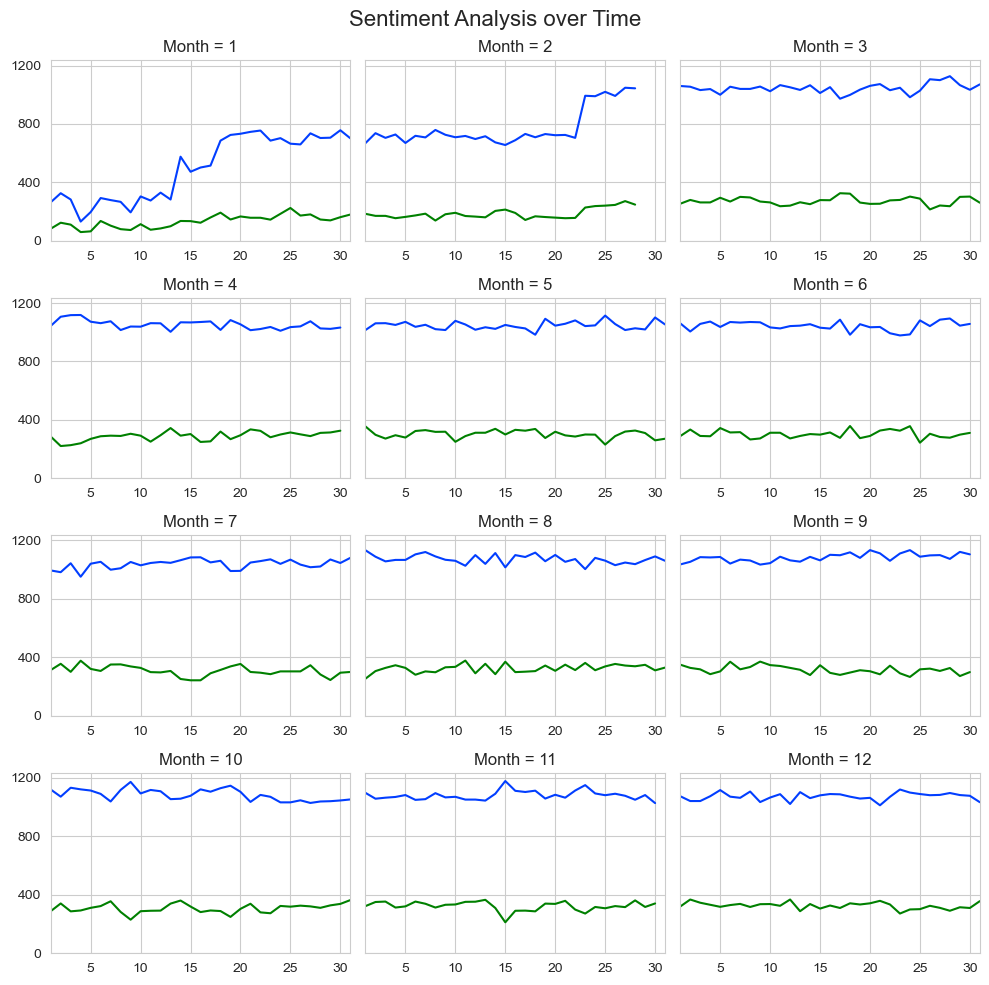

In [ ]:
time_plot(count_sentiment_model)

#### VADER Sentiment:

In [ ]:
# Counting total sentiments over time:
positive_sentiment_vader = sentiment_df_vader[sentiment_df_vader['Sentiment'] == 1].groupby(['Month', 'Day'])['Sentiment'].count().reset_index(name='Positive')
neutral_sentiment_vader = sentiment_df_vader[sentiment_df_vader['Sentiment'] == 0].groupby(['Month', 'Day'])['Sentiment'].count().reset_index(name='Neutral')
negative_sentiment_vader = sentiment_df_vader[sentiment_df_vader['Sentiment'] <= 0].groupby(['Month', 'Day'])['Sentiment'].count().reset_index(name='Negative')
count_sentiment_vader = pd.merge(negative_sentiment_vader, neutral_sentiment_vader, how='outer', on=['Month', 'Day'])
count_sentiment_vader = pd.merge(count_sentiment_vader, positive_sentiment_vader, how='outer', on=['Month', 'Day'])
count_sentiment_vader.fillna(0, inplace=True)

# Not interested in neutral. Neutral was added to negative column:
count_sentiment_vader.drop(columns=['Neutral']).head()

,Month,Day,Negative,Positive
0,1,1,195,152
1,1,2,238,212
2,1,3,217,177
3,1,4,109,83
4,1,5,149,113


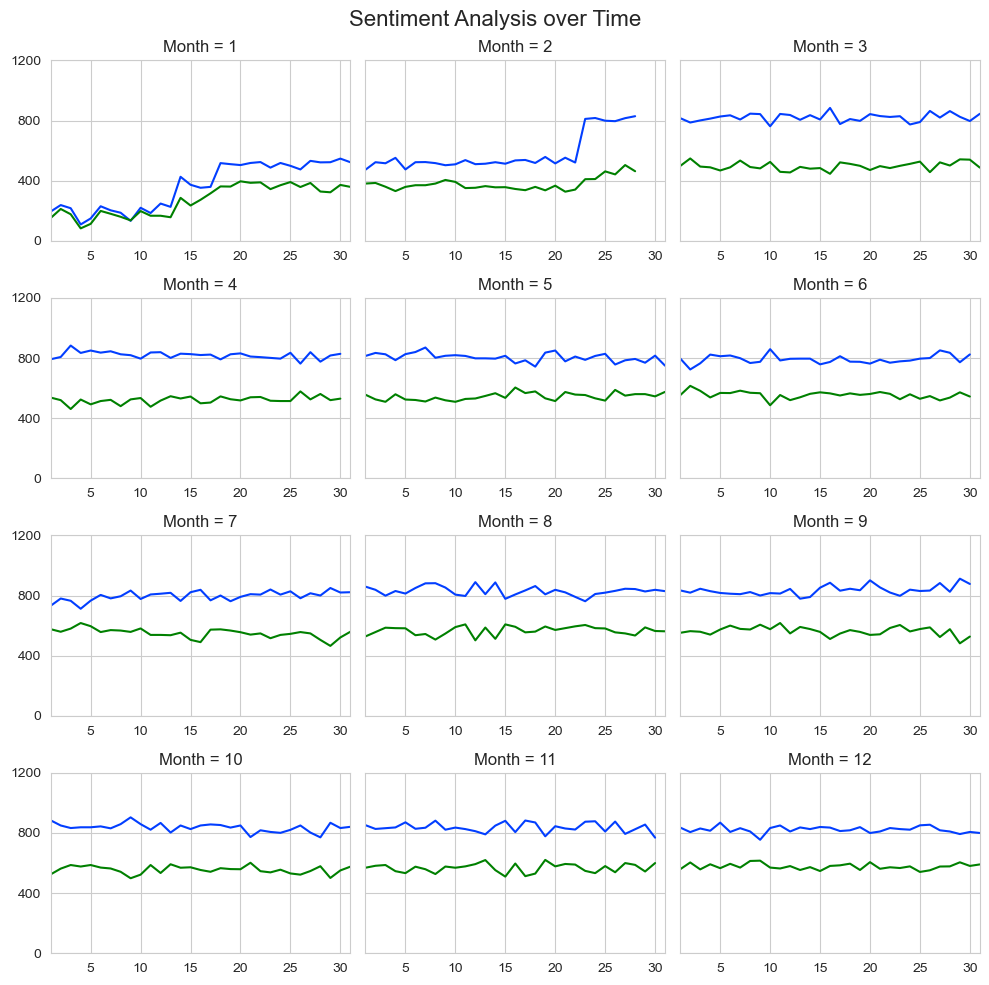

In [ ]:
time_plot(count_sentiment_vader)

We observe that the time series predicted by our best model and VADER show a sudden jump in negative sentiments at **February 22nd 2022**, coinciding with the day the Russian government initiated an unprovoked full-scale invasion on Ukraine, which was met with international condemnation. This event dominated global headlines and social media platforms, with users expressing their outrage and concern over the humanitarian crisis and potential geopolitical consequences. Our sentiment analysis results thus align with the widely shared negative sentiment towards this event.

### 4.2. Word Clouds for 2022 Reddit Data:

In this section, word clouds are used for visualization purposes, leveraging Vader predictions to exclude neutral comments. Two sets of word clouds were generated: one for the entire 2022 Reddit data, and another specifically for the last week of February 2022, which coincided with the onset of the Russia-Ukraine war. Positive and negative sentiments are masked with the map of Ukraine and Russia, respectively.

#### Load masks:

In [ ]:
if not use_colab_gdrive:
    # Load the image of Ukraine as a NumPy array:
    with open("ukraine_map.png", "rb") as f:
        # Read the contents of the file as bytes
        image_bytes = f.read()

    # Convert the bytes to a PIL Image object
    image_pil = Image.open(BytesIO(image_bytes))

    # Convert the PIL Image to a NumPy array
    ukraine_mask = np.array(image_pil)
else:
    # Set the URL for the image file:
    url = "https://drive.google.com/file/d/1uEGE7OJ__JL_L_5pC8S6rAbgsy4GFnfR/view?usp=share_link"

    # Extract file ID from URL:
    file_id = url.split('/')[-2]

    # Set destination file path and name:
    destination = "ukraine_map.png"

    # Download file from Google Drive:
    response = requests.get(f"https://drive.google.com/uc?id={file_id}")
    content = response.content

    # Save file locally:
    with open(destination, 'wb') as f:
        f.write(content)

    # Load the image of Ukraine as a NumPy array:
    with open(destination, "rb") as f:
        # Read the contents of the file as bytes
        image_bytes = f.read()

    # Convert the bytes to a PIL Image object
    image_pil = Image.open(BytesIO(image_bytes))

    # Convert the PIL Image to a NumPy array
    ukraine_mask = np.array(image_pil)

In [ ]:
if not use_colab_gdrive:
    # Load the image of Russia as a NumPy array:
    with open("russia_map.png", "rb") as f:
        # Read the contents of the file as bytes
        image_bytes = f.read()

    # Convert the bytes to a PIL Image object
    image_pil = Image.open(BytesIO(image_bytes))

    # Convert the PIL Image to a NumPy array
    russia_mask = np.array(image_pil)
else:
    # Set the URL for the image file:
    url = "https://drive.google.com/file/d/1Hy80zDxnnyE2U0xHg-EdwWKjkD7z8PXA/view?usp=share_link"

    # Extract file ID from URL:
    file_id = url.split('/')[-2]

    # Set destination file path and name:
    destination = "russia_map.png"

    # Download file from Google Drive:
    response = requests.get(f"https://drive.google.com/uc?id={file_id}")
    content = response.content

    # Save file locally:
    with open(destination, 'wb') as f:
        f.write(content)

    # Load the image of Ukraine as a NumPy array:
    with open(destination, "rb") as f:
        # Read the contents of the file as bytes
        image_bytes = f.read()

    # Convert the bytes to a PIL Image object
    image_pil = Image.open(BytesIO(image_bytes))

    # Convert the PIL Image to a NumPy array
    russia_mask = np.array(image_pil)

#### Load stopwords:

In [ ]:
if not use_colab_gdrive:
    # Removing as many stopwords as possible:
    with open('stop_words_english.txt', 'r', encoding='utf-8') as f:
        sw_en = set(f.read().splitlines())
else:
    # Set the URL for the text file on Google Drive:
    url = "https://drive.google.com/file/d/1qB22TktD1zmPhy1AcC9Ni3d4uJq6FDd7/view?usp=share_link"

    # Extract file ID from URL:
    file_id = url.split('/')[-2]

    # Set destination file path and name:
    destination = "stop_words_english.txt"

    # Download file from Google Drive:
    response = requests.get(f"https://drive.google.com/uc?id={file_id}")
    content = response.content

    # Save file locally:
    with open(destination, 'wb') as f:
        f.write(content)

    # Load stop words:
    with open(destination, 'r', encoding='utf-8') as f:
        sw_en = set(f.read().splitlines())

In [ ]:
def word_cloud(text, mask):
    text = " ".join(w for w in text)

    # Define the list of stopwords:
    sw = STOPWORDS

    # Create a WordCloud object with the given parameters
    wc = WordCloud(stopwords=sw|sw_en, max_words=400, mask=mask, background_color="white")

    # Generate the word cloud
    wc.generate(text)

    return wc

#### Sentiments in 2022:

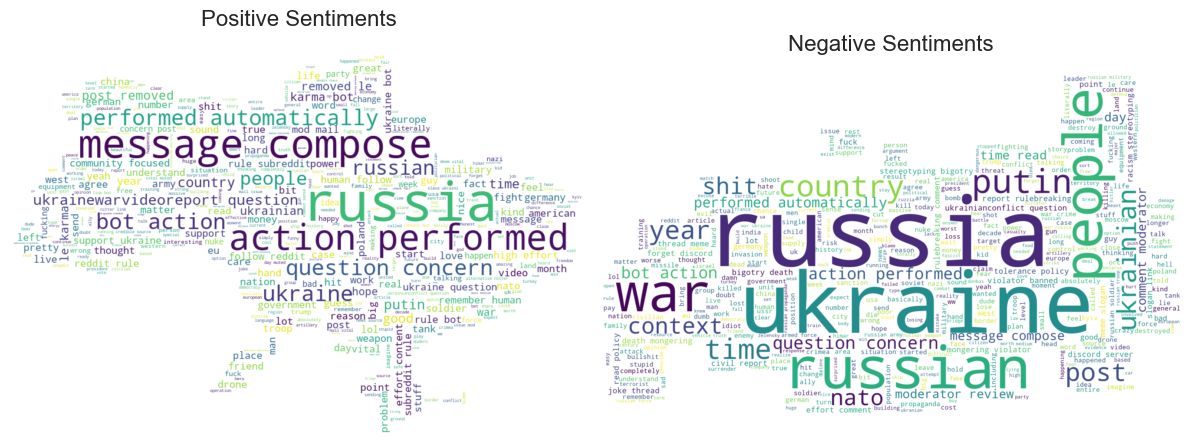

In [ ]:
# Extract data:
sentiment_df = sentiment_df_vader
idx = (sentiment_df['Sentiment']>0)
positive_text = sentiment_df.loc[idx]['Clean'].tolist()
idx = (sentiment_df['Sentiment']<0)
negative_text = sentiment_df.loc[idx]['Clean'].tolist()

# Generate the first word cloud:
wc1 = word_cloud(positive_text, ukraine_mask)

# Generate the second word cloud:
wc2 = word_cloud(negative_text, russia_mask)

# Display the two word clouds side by side:
fig, axs = plt.subplots(ncols=2, figsize=(12, 8))

# Show the first word cloud on the left:
axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Positive Sentiments', fontsize=16, y=1.05)
axs[0].axis("off")

# Show the second word cloud on the right:
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Negative Sentiments', fontsize=16, y=1.05)
axs[1].axis("off")

# Display the plots:
plt.tight_layout()
plt.show()

#### Sentiments in February 2022:

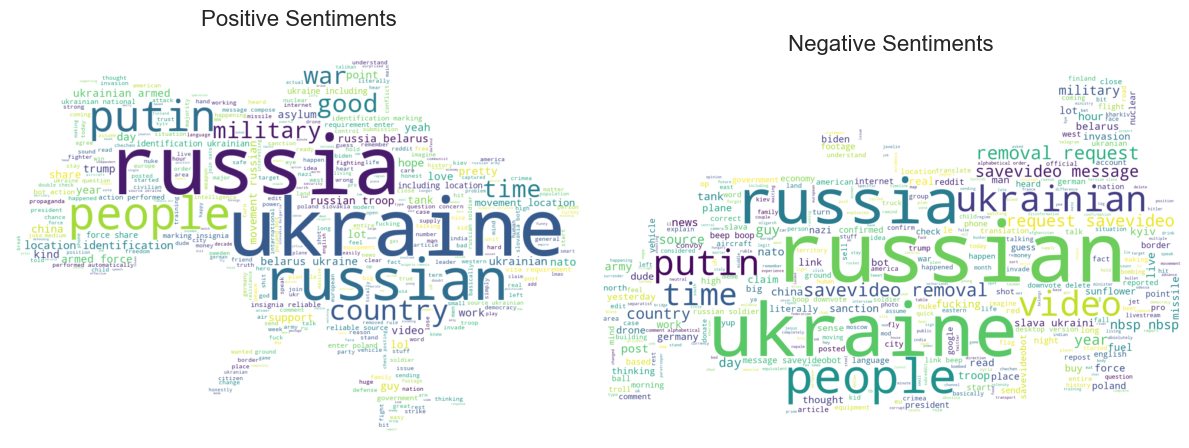

In [ ]:
# Extract data:
sentiment_df = sentiment_df_vader
idx = (sentiment_df['Sentiment']>0) & (sentiment_df['Month']==2) & (sentiment_df['Day']>=22)
positive_text = sentiment_df.loc[idx]['Clean'].tolist()
idx = (sentiment_df['Sentiment']==0) & (sentiment_df['Month']==2) & (sentiment_df['Day']>=22)
negative_text = sentiment_df.loc[idx]['Clean'].tolist()

# Generate the first word cloud:
wc1 = word_cloud(positive_text, ukraine_mask)

# Generate the second word cloud:
wc2 = word_cloud(negative_text, russia_mask)

# Display the two word clouds side by side:
fig, axs = plt.subplots(ncols=2, figsize=(12, 8))

# Show the first word cloud on the left:
axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Positive Sentiments', fontsize=16, y=1.05)
axs[0].axis("off")

# Show the second word cloud on the right:
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Negative Sentiments', fontsize=16, y=1.05)
axs[1].axis("off")

# Display the plots:
plt.tight_layout()
plt.show()